# GRT Development: Jacobians

In [7]:
import spiceypy as spy
from matplotlib import pyplot as plt
import pandas as pd
from time import time,strftime
import numpy as np
%matplotlib nbagg
TIME=time()

import tarfile

#Numerical
DEG=np.pi/180
RAD=1/DEG

BDIR=f"./"
DATADIR=f"{BDIR}/data/"
KERDIR=f"{BDIR}/../gravray/data/"
FIGDIR=f"{BDIR}/papers/paper1/figures/"

def elTime(verbose=True):
    global TIME
    t=time()
    dt=t-TIME
    if verbose:print("%.3f s, %.3f min, %g h"%(dt,dt/60.0,dt/3600.0))
    TIME=t
    
def computeJacobian(jfun,x,dx,N=6,**args):
    variables={}
    J=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            pre=[x[k] for k in range(j)]
            pos=[x[k] for k in range(j+1,N)]
            yi=lambda t:jfun(pre+[t]+pos,**args)[i]
            dyidxj=(yi(x[j]+dx[j])-yi(x[j]-dx[j]))/(2*dx[j])
            J[i,j]=dyidxj
    return J

In [5]:
%matplotlib nbagg

Example in: ich2.pdf

x1 ~ Gamma(nu1,lambda)

x2 ~ Gamma(nu2,lambda)

In [46]:
from scipy.stats import gamma,beta
from scipy.special import gamma as gammafunc
from scipy.optimize import minimize

def GammaGamma(r,params):
    n1,q1=params[:2]
    n2,q2=params[2:]
    g1=myGamma(n1,q1)
    g2=myGamma(n2,q2)
    G=g1.pdf(r[0])*g2.pdf(r[1])
    return G

In [47]:
gamma(1.0,scale=2)

In [48]:
def expGamma(x,nu,lamb):
    y=x**(nu-1)*np.exp(-x/lamb)/(lamb**nu*gammafunc(nu))
    return y

myGamma=lambda nu,lamb:gamma(nu,scale=lamb)

In [49]:
nu1=1.5
nu2=3.0
lamb=lamb1=lamb2=1.0
params=[nu1,lamb1,nu2,lamb2]


<IPython.core.display.Javascript object>


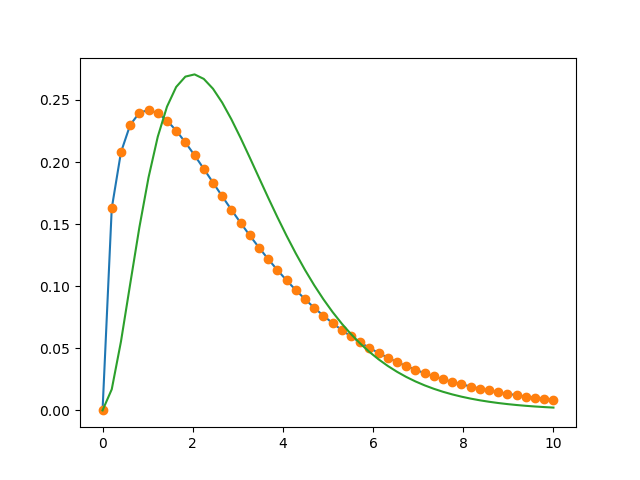

In [50]:
x1=np.linspace(0,10.0)
g1=myGamma(nu1,2.0)
p1=g1.pdf(x1)
x2=np.linspace(0,10.0)
p2=gamma.pdf(x2,nu2)

pe1=expGamma(x1,nu1,2)

fig=plt.figure()
ax=fig.gca()

ax.plot(x1,p1)
ax.plot(x1,pe1,'o')
ax.plot(x2,p2)

In [51]:
g1=myGamma(nu1,lamb1)
g2=myGamma(nu2,lamb2)

mod1=(nu1-1)*lamb1
mean1=nu1*lamb1
std1=np.sqrt(nu1)*lamb1
max1=mean1+3*std1
mod2=(nu2-1)*lamb2
mean2=nu2*lamb2
std2=np.sqrt(nu2)*lamb2
max2=mean2+3*std2

minusMultipdf=lambda r:-GammaGamma(r,params)
solution=minimize(minusMultipdf,[1,1])
fmax=-solution.fun
rmax=solution.x

print(mod1,mean1,std1,max1)
print(mod2,mean2,std2,max2)
print(fmax,rmax)

0.5 1.5 1.224744871391589 5.174234614174766
2.0 3.0 1.7320508075688772 8.196152422706632
0.13098870578722166 [0.50003008 1.99991345]


<IPython.core.display.Javascript object>


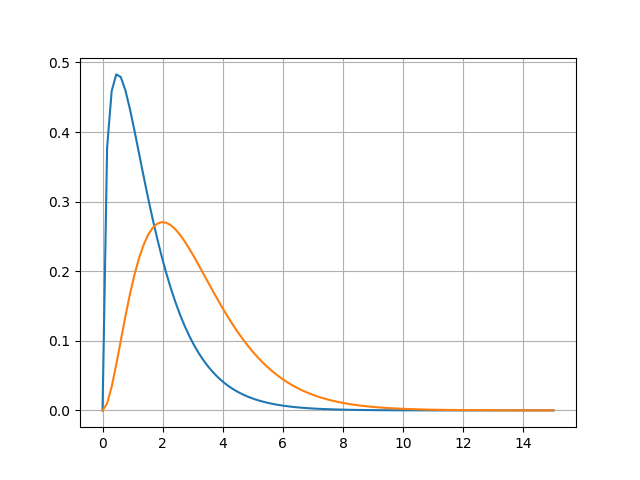

In [52]:
x=np.linspace(0,15,100)
fig=plt.figure()
ax=fig.gca()

ax.plot(x,g1.pdf(x))
ax.plot(x,g2.pdf(x))

ax.grid()

<IPython.core.display.Javascript object>


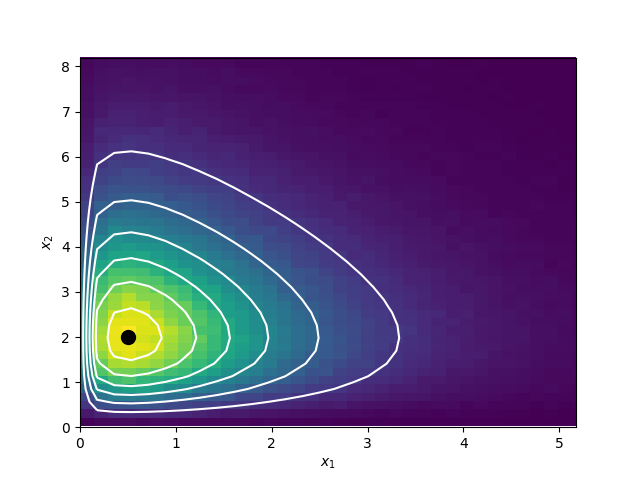

(0, 8.196152422706632)

In [53]:
N1=N2=30
x1=np.linspace(0,max1,N1)
x2=np.linspace(0,max2,N2)

g1=myGamma(nu1,lamb1)
g2=myGamma(nu2,lamb2)

X1,X2=np.meshgrid(x1,x2)

P=np.zeros((N1,N2))
for i,x in enumerate(x1):
    for j,y in enumerate(x2):
        #P[j,i]=GammaGamma([x,y],params)
        P[j,i]=g1.pdf(x)*g2.pdf(y)

Nu=1000000
xu1=g1.rvs(Nu)
xu2=g2.rvs(Nu)
Xu=np.vstack((xu1,xu2)).transpose()
#Xu2=multiReject(GammaGamma,params,[0,0],[max1,max2],1000,fmax)

fig=plt.figure()
ax=fig.gca()

ax.contour(X1,X2,P,colors='w')
#ax.contourf(X1,X2,P)
#ax.scatter(Xu[:,0],Xu[:,1],color=['r'],sizes=[0.6])
ax.hist2d(Xu[:,0],Xu[:,1],bins=100)

ax.plot(rmax[0],rmax[1],'ko',ms=10)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

ax.set_xlim((0,max1))
ax.set_ylim((0,max2))

In [54]:
def multiReject(multipdf,params,rmin,rmax,N,fmax=1.0):
    n=len(rmin)
    i=0
    rs=[]
    while True:
        r=[np.random.uniform(rmin[i],rmax[i]) for i in range(n)] 
        p=multipdf(r,params)
        u=np.random.uniform(0,fmax)
        if u>p:continue
        rs+=[r]
        i+=1
        if i>=N:break
    return np.array(rs)

<IPython.core.display.Javascript object>


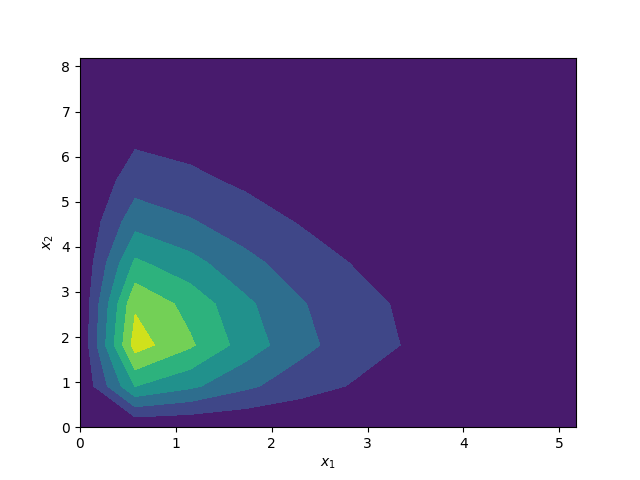

(0, 8.196152422706632)

In [55]:
N1=N2=10

x1=np.linspace(0,max1,N1)
x2=np.linspace(0,max2,N2)
X1,X2=np.meshgrid(x1,x2)

fig=plt.figure()
ax=fig.gca()

GG=np.zeros((N1,N2))
for i,x in enumerate(x1):
    for j,y in enumerate(x2):
        GG[j,i]=GammaGamma([x,y],params)

#ax.contour(X1,X2,GG,colors='w')
ax.contourf(X1,X2,GG)

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

ax.set_xlim((0,max1))
ax.set_ylim((0,max2))

In [56]:
minusMultipdf=lambda r:-GammaGamma(r,params)
solution=minimize(minusMultipdf,[1,1])
fmax=-solution.fun
fmax

0.13098870578722166

In [57]:
Xu=multiReject(GammaGamma,params,[0,0],[max1,max2],10,fmax)

## Convert

In [58]:
yu1=xu1+xu2
yu2=xu1/(xu1+xu2)
Yu=np.vstack((yu1,yu2)).transpose()

<IPython.core.display.Javascript object>


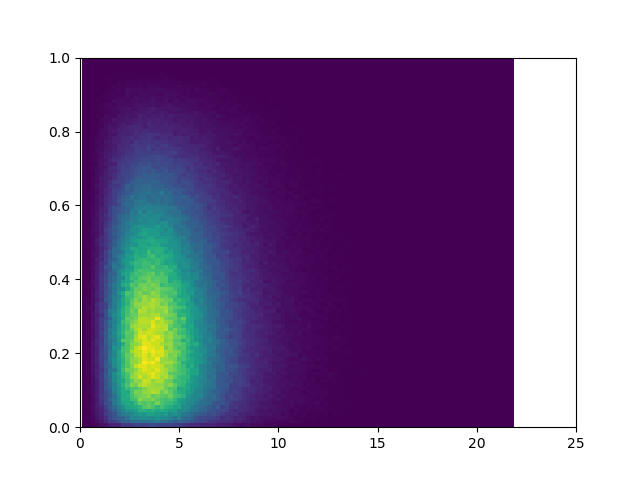

(0, 1)

In [59]:
fig=plt.figure()
ax=fig.gca()

ax.hist2d(Yu[:,0],Yu[:,1],bins=100)

ax.set_xlim((0,25))
ax.set_ylim((0,1))

In [60]:
N1=N2=50
ys1=np.linspace(0.001,25,N1)
ys2=np.linspace(0.001,1,N2)
Y1,Y2=np.meshgrid(ys1,ys2)
Py=np.zeros((N1,N2))

#Conversion is:
#y = t(x)
#x = t^-1(y)
for i,y1 in enumerate(ys1):
    for j,y2 in enumerate(ys2):
        x1=y1*y2
        x2=y1-y1*y2

        #Conversion from x to y: Jxy = = |dx/dy| = |dt^-1(y)/dy|
        Jxy=np.array([[y2,y1],[1-y2,-y1]])
        detJxy=np.linalg.det(Jxy)
        
        #Conversion from y to x: Jyx = |dy/dx| = |dt(x)/dx|
        Jyx=np.array([[1,1],[x2/(x1+x2)**2,-x1/(x1+x2)**2]])
        detJyx=np.linalg.det(Jyx)
     
        #Property: detJxy = 1/detJyx
    
        #Probability
        Py[j,i]=g1.pdf(x1)*g2.pdf(x2)*(detJxy)
        #Py[j,i]=g1.pdf(x1)*g2.pdf(x2)*(1/detJyx)

<IPython.core.display.Javascript object>


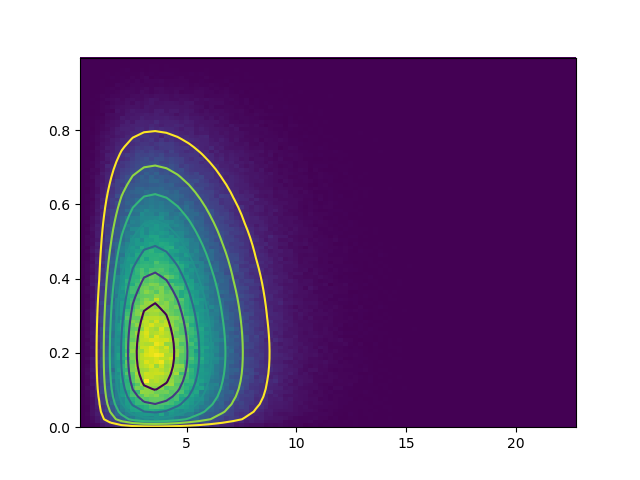

In [61]:
#Theoretical distribution
gy1=myGamma(nu1+nu2,lamb)
gy2=beta(nu1,nu2)
Nun=1000000
yu1=gy1.rvs(Nun)
yu2=gy2.rvs(Nun)
Yun=np.vstack((yu1,yu2)).transpose()

fig=plt.figure()
ax=fig.gca()

#ax.scatter(Yun[:,0],Yun[:,1],color=['r'],sizes=[0.6])

#Theoretical
ax.contour(Y1,Y2,Py,color=['w'])
#h2=ax.hist2d(Yu[:,0],Yu[:,1],bins=100)

#Generated
h2=ax.hist2d(Yun[:,0],Yun[:,1],bins=100)

#ax.set_xlim((0,40))
#ax.set_ylim((0,1))

### Multiple transformation

In this part of the Notebook we will explore what happen when we have multiple transformation, how the Jacobians can be "piled-up"

In [76]:
#Parameters
nu1=1.5
nu2=3.0
lamb=1.0

mod1=(nu1-1)*lamb
mean1=nu1*lamb
std1=np.sqrt(nu1)*lamb
max1=mean1+3*std1
mod2=(nu2-1)*lamb
mean2=nu2*lamb
std2=np.sqrt(nu2)*lamb
max2=mean2+3*std2

In [77]:
#Generate sample of (x1,x2):
g1=myGamma(nu1,lamb)
g2=myGamma(nu2,lamb)
Nu=1000000
xu1=g1.rvs(Nu)
xu2=g2.rvs(Nu)
Xu=np.vstack((xu1,xu2)).transpose()

In [81]:
#Theoretical distribution
N1=N2=30
x1=np.linspace(0,max1,N1)
x2=np.linspace(0,max2,N2)

X1,X2=np.meshgrid(x1,x2)
Px=np.zeros((N1,N2))
for i,x in enumerate(x1):
    for j,y in enumerate(x2):
        Px[j,i]=g1.pdf(x)*g2.pdf(y)

<IPython.core.display.Javascript object>


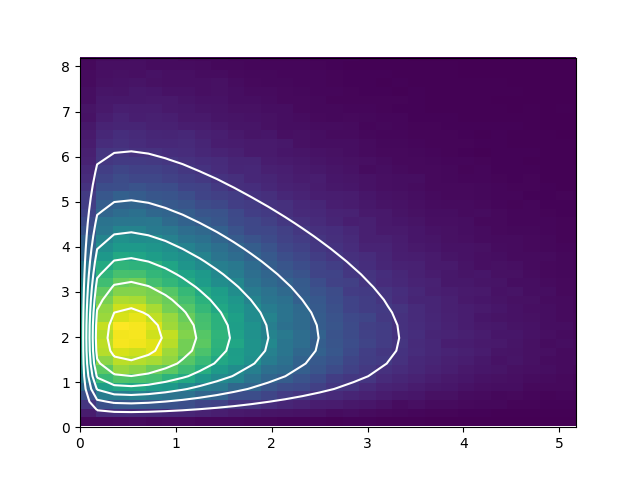

(0, 8.196152422706632)

In [82]:
#Sample vs. Theory
fig=plt.figure()
ax=fig.gca()

ax.contour(X1,X2,Px,colors='w')
h2=ax.hist2d(Xu[:,0],Xu[:,1],bins=100)

ax.set_xlim((0,max1))
ax.set_ylim((0,max2))

In [83]:
#Computhe the sample of (y1,y2)
yu1=xu1+xu2
yu2=xu1/(xu1+xu2)
Yu=np.vstack((yu1,yu2)).transpose()

In [193]:
min(yu1),max(yu1),min(yu2),max(yu2)

(0.11781726954026867,
 24.763204784340978,
 5.294737096502719e-05,
 0.9896455610253311)

In [250]:
#Theoretical distribution
N1=N2=50
ys1=np.linspace(0.001,25,N1)
ys2=np.linspace(0.001,1,N2)
Y1,Y2=np.meshgrid(ys1,ys2)
Py=np.zeros((N1,N2))

#Conversion is:
#y = t(x)
#x = t^-1(y)
for i,y1 in enumerate(ys1):
    for j,y2 in enumerate(ys2):
        x1=y1*y2
        x2=y1-y1*y2

        #Conversion from x to y: Jxy = = |dx/dy| = |dt^-1(y)/dy|
        Jxy=np.array([[y2,y1],[1-y2,-y1]])
        detJxy=np.linalg.det(Jxy)
        
        #Probability
        Py[j,i]=g1.pdf(x1)*g2.pdf(x2)*np.abs(detJxy)

<IPython.core.display.Javascript object>


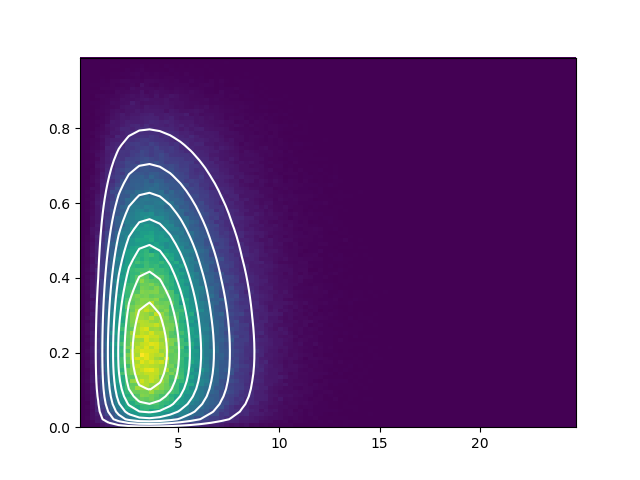

In [251]:
fig=plt.figure()
ax=fig.gca()

ax.contour(Y1,Y2,Py,colors='w')
h2=ax.hist2d(Yu[:,0],Yu[:,1],bins=100)

In [264]:
#Computhe the sample of (z1,z2)
zu1=np.sqrt(yu2)
zu2=np.sqrt(yu1)
Zu=np.vstack((zu1,zu2)).transpose()

<IPython.core.display.Javascript object>


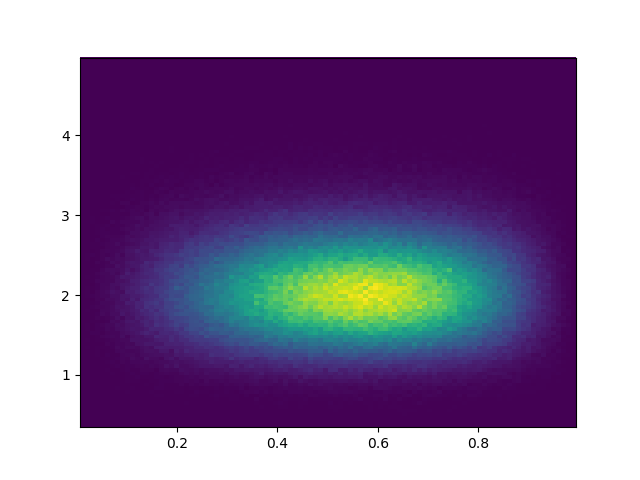

In [265]:
fig=plt.figure()
ax=fig.gca()

h2=ax.hist2d(Zu[:,0],Zu[:,1],bins=100)

In [266]:
def yfun(z):
    z1,z2=z
    y1=z2**2
    y2=z1**2
    return [y1,y2]
def zfun(y):
    y1,y2=y
    z1=np.sqrt(y2)
    z2=np.sqrt(y1)
    return [z1,z2]

In [267]:
z=[0.2,0.3]
dz=[1e-6]*2
Jyz=computeJacobian(yfun,z,dz,N=2)
print(Jyz)
y=yfun(z)
dy=[1e-6]*2
Jzy=computeJacobian(zfun,y,dy,N=2)
print(Jzy)
print(np.linalg.inv(Jyz))

[[0.  0.6]
 [0.4 0. ]]
[[0.         2.5       ]
 [1.66666667 0.        ]]
[[0.         2.5       ]
 [1.66666667 0.        ]]


In [268]:
def calcJyz(z):
    z1,z2=z
    y1,y2=yfun(z)
    
    #d/dz1
    Jz1=[0,2*z1]
    
    #d/dz2
    Jz2=[2*z2,0]
    
    J=np.array([Jz1,Jz2]).transpose()
    
    return J

def calcJxz(z):
    z1,z2=z
    
    #d/dz1
    Jz1=[2*z1*z2**2,-2*z1*z2**2]
    
    #d/dz2
    Jz2=[2*z1**2*z2,2*z2]
    
    J=np.array([Jz1,Jz2]).transpose()
    
    return J


In [269]:
#Compute the distribution of (z1,z2)
#Theoretical distribution
N1=N2=50

zs1=np.linspace(0.001,1,N1)
zs2=np.linspace(0.001,10,N2)

Z1,Z2=np.meshgrid(zs1,zs2)

Pz=np.zeros((N1,N2))

#Conversion is:
#y = u(x)
#x = t^-1(y)
#z = u(y)
#y = u^-1(z)
y1s=[]
y2s=[]
for i,z1 in enumerate(zs1):
    for j,z2 in enumerate(zs2):
        
        y1=z2**2
        y2=z1**2

        x1=y1*y2
        x2=y1-y1*y2
        
        
        #Conversion from x to y: Jxy = |dx/dy| = |dt^-1(y)/dy|
        Jxy=np.array([[y2,y1],[1-y2,-y1]])
        detJxy=np.linalg.det(Jxy)
        
        #Conversion from y to z: Jyz = |dy/dz| = |du^-1(z)/dz|
        Jyz=calcJyz([z1,z2])
        detJyz=np.linalg.det(Jyz)
        
        #Conversion from x to z: Jxz = |dx/dz| 
        Jxz=calcJxz([z1,z2])
        detJxz=np.linalg.det(Jxz)
                
        #Probability
        Pz[j,i]=g1.pdf(x1)*g2.pdf(x2)*np.abs(detJxy)*np.abs(detJyz)

In [298]:
#Check normalization
dz1=zs1[1]-zs1[0];dz2=zs2[1]-zs2[0]
suma=0
for i in range(N1):
    for j in range(N2):
        suma+=Pz[j,i]*dz1*dz2
suma

0.9999989932902901

<IPython.core.display.Javascript object>


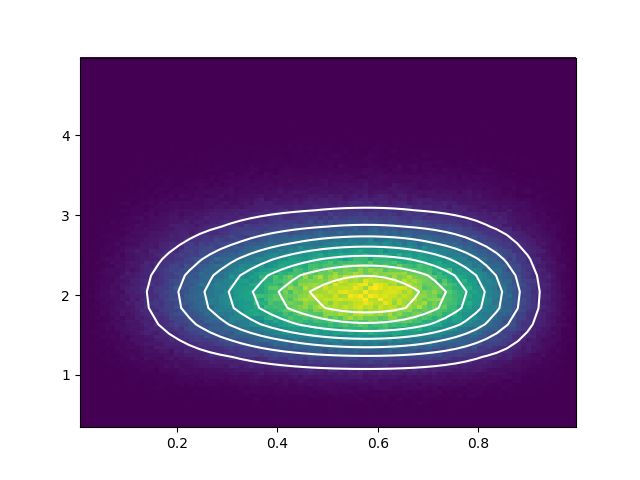

In [270]:
fig=plt.figure()
ax=fig.gca()

h2=ax.hist2d(Zu[:,0],Zu[:,1],bins=100)
ax.contour(Z1,Z2,Pz,colors='w')

#ax.set_xlim((0,1))
#ax.set_ylim((0,10))

## Orbital elements

In [3]:
from scipy.optimize import minimize

def unflattenParameters(params):
    import spiceypy as spy
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-np.sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))
    
    rots=[]
    covs=[]
    for scale,angle in zip(scales,angles):
        L=np.identity(len(scale))*np.outer(np.ones(len(scale)),scale)
        rots+=[spy.eul2m(-angle[0],-angle[1],-angle[2],3,1,3)]
        covs+=[spy.mxm(spy.mxm(rots[-1],spy.mxm(L,L)),spy.invert(rots[-1]))]
        
    return weights,locs,scales,angles,rots,covs

def map2Inf(x,scale=1):
    """
    Map variable x from the interval [0,scale] to a new variable t in the interval [-inf,+inf].
    x = 0 correspond to t->-inf
    x = 1 correspond to t->+inf
    """
    u=x/scale
    t=np.log(u/(1-u))
    return t

def map2Fin(t,scale=1):
    """
    Map variable t from the interval (-inf,inf) to a new variable x in the interval [0,scale].
    t->-inf correspond to x = 0
    t->+inf correspond to x = 1
    """
    x=scale/(1+np.exp(-t))
    return x

def multiNorm(r,weights,locs,covs):
    value=0
    for w,loc,cov in zip(weights,locs,covs):
        value+=w*multinorm.pdf(r,loc,cov)
    return value

def multiNormMarginal(vf,weights,locs,covs,v1,v2,perm):
    """
    Marginal.
    vf: Value of the main variable.
    v1,v2: Value of the marginalized variables.
    perm: order on which the variables should be passed to the multiNorm3D funcition.
      Ex. perm=[1,2,3], vf will be x (1), v1 will be y, v2 will be z
          perm=[2,3,1], vf will be z, v1 will be x, v2 will be y
    """
    v=[vf,v1,v2]
    r=[v[perm[0]-1],v[perm[1]-1],v[perm[2]-1]]
    p=multiNorm(r,weights,locs,covs)
    return p

from scipy.stats import multivariate_normal as multinorm
from scipy.integrate import quad as integral

def multiNorm3D(r,params,verbose=False):
    """
    p(r;w,mu,s,a) = \Sum_i w_i G(r,mu_i,s_i,cov_i)
    """
    #Check if it is one function
    #Unflatten parameters
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))

    #Generate covariance matrices
    covs=linearCovariance(scales,angles)    

    if verbose:
        print("Weights:",weights)
        print("Locations:",locs)
        print("Scales:",scales)
        print("Covariances:",covs)
    
    #Compute function
    value=0
    for w,loc,cov in zip(weights,locs,covs):
        value+=w*multinorm.pdf(r,loc,cov)
    return value

def multiNorm3DMax(params):
    
    #Find position of the maximum and maximum value
    imultiNorm3D=lambda r,params:-multiNorm3D(r,params)
    solution=minimize(imultiNorm3D,[0,0,0],args=(params,))
    
    #Find range
    N=len(params)
    if N>9:
        M=np.int((len(params)+1)/10)
        i=0;j=i+M-1
        weights=list(params[i:j])+[1-sum(params[i:j])]
    else:
        #Case for one function
        M=1
        weights=[1.0]
        j=0
    i=j;j=i+3*M
    locs=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    scales=np.reshape(params[i:j],(M,3))
    i=j;j=i+3*M
    angles=np.reshape(params[i:j],(M,3))
    
    rmaxs=[]
    rmins=[]
    for i in range(M):
        rmaxs+=[locs[i]+2.5*scales[i]]
        rmins+=[locs[i]-2.5*scales[i]]
    rmaxs=np.array(rmaxs)
    rmins=np.array(rmins)
    vmax=rmaxs.max(axis=0)
    vmin=rmins.min(axis=0)
    
    return solution,vmin,vmax

def multiReject(params,N):
    multiNorm3DMax(params)
    solution,vmin,vmax=multiNorm3DMax(params)
    pmax=-solution.fun
    vmin[2]=-7
    i=0
    rs=[]
    while True:
        r=[np.random.uniform(vmin[i],vmax[i]) for i in range(3)] 
        p=multiNorm3D(r,params)
        u=np.random.uniform(0,pmax)
        if u>p:continue
        rs+=[r]
        i+=1
        if i>=N:break
    return np.array(rs),vmin,vmax

In [4]:
params=np.array([0.6,
                 0.5,0.5,-2.0,
                 2.0,0.3,-2.6,
                 1.3,0.7,0.5,
                 0.4,0.9,1.6,
                 -0.7,-1.5,0.0,
                 1.4,-1.9,0.0])

In [5]:
weights,locs,scales,angles,rots,covs=unflattenParameters(params)
print(f"Weights: {weights}")
print(f"Locs: {locs}")
print(f"Scales: {scales}")
weights,locs,scales,angles*RAD

Weights: [0.6, 0.4]
Locs: [[ 0.5  0.5 -2. ]
 [ 2.   0.3 -2.6]]
Scales: [[1.3 0.7 0.5]
 [0.4 0.9 1.6]]


([0.6, 0.4], array([[ 0.5,  0.5, -2. ],
        [ 2. ,  0.3, -2.6]]), array([[1.3, 0.7, 0.5],
        [0.4, 0.9, 1.6]]), array([[ -40.10704566,  -85.94366927,    0.        ],
        [  80.21409132, -108.86198107,    0.        ]]))

In [6]:
locs[0]

array([ 0.5,  0.5, -2. ])

In [7]:
multiNorm(locs[0],weights,locs,covs)

0.09997273597873046

In [46]:
NX=NY=NZ=15
vmax=6
xvec=np.linspace(-vmax,vmax,NX)
yvec=np.linspace(-vmax,vmax,NY)
zvec=np.linspace(-vmax,vmax,NZ)
Xxy,Yxy=np.meshgrid(xvec,yvec)
Xxz,Zxz=np.meshgrid(xvec,zvec)
Yyz,Zyz=np.meshgrid(yvec,zvec)

In [8]:

PXY=np.zeros((NX,NY))
for i,x in enumerate(xvec):
    for j,y in enumerate(yvec):
        PXY[j,i]=integral(multiNormMarginal,-np.inf,np.inf,args=(weights,locs,covs,x,y,[2,3,1]))[0]
        
PXZ=np.zeros((NX,NZ))
for i,x in enumerate(xvec):
    for j,z in enumerate(zvec):
        PXZ[j,i]=integral(multiNormMarginal,-np.inf,np.inf,args=(weights,locs,covs,x,z,[2,1,3]))[0]

PYZ=np.zeros((NY,NZ))
for i,y in enumerate(yvec):
    for j,z in enumerate(zvec):
        PYZ[j,i]=integral(multiNormMarginal,-np.inf,np.inf,args=(weights,locs,covs,y,z,[1,2,3]))[0]

In [9]:
vmax=6

### Generate data

In [10]:
def genIndex(probs):
    """
    Given a set of (normalized) randomly generate the index n following the probabilities.
    For instance if we have 3 events with probabilities 0.1, 0.7, 0.2, genSample will generate
    a number in the set (0,1,2) with those probabilities.

    Parameters:
        probs: Probabilities, numpy array (N), adimensional
        NOTE: It should be normalized, ie. sum(probs)=1

    Return:
        n: Index in interval [0,1,2,... len(probs)-1], integer
    """
    cond=(np.random.rand()-np.cumsum(probs))<0
    isort=np.arange(len(probs))
    n=isort[cond][0] if sum(cond)>0 else isort[0]
    return n

In [11]:
weights

[0.6, 0.4]

In [12]:
covs

[array([[ 1.09287474, -0.70893209, -0.01090944],
        [-0.70893209,  0.84832616, -0.01295214],
        [-0.01090944, -0.01295214,  0.4887991 ]]),
 array([[ 2.31304742, -0.37135057,  0.52758579],
        [-0.37135057,  0.22404933, -0.09099627],
        [ 0.52758579, -0.09099627,  0.99290325]])]

In [13]:
elTime(False)
N=100000
rs=[]
for i in range(N):
    n=genIndex(weights)
    r=multinorm.rvs(locs[n],covs[n])
    rs+=[r]
rs=np.array(rs)
elTime(True)

32.071 s, 0.535 min, 0.00890862 h


In [57]:
N=15
Hxy,xs,ys=np.histogram2d(rs[:,0],rs[:,1],bins=N)
xms=(xs[1:]+xs[:-1])/2
yms=(ys[1:]+ys[:-1])/2
Hxz,xs,zs=np.histogram2d(rs[:,0],rs[:,2],bins=N)
zms=(zs[1:]+zs[:-1])/2

In [60]:
P=np.zeros((N,N,N))
for i,x in enumerate(xms):
    for j,y in enumerate(yms):
        for k,z in enumerate(zms):
            P[i,j,k]=multiNorm([x,y,z],weights,locs,covs)
Ymxy,Xmxy=np.meshgrid(yms,xms)
Zmxz,Xmxz=np.meshgrid(zms,xms)
Zmyz,Ymyz=np.meshgrid(zms,yms)

In [66]:
#Marginals
Hmxy=np.zeros((N,N))
for i,x in enumerate(xms):
    for j,y in enumerate(yms):
        Hmxy[i,j]=P[i,j,:].sum()
Hmxz=np.zeros((N,N))
for i,x in enumerate(xms):
    for j,z in enumerate(zms):
        Hmxz[i,j]=P[i,:,j].sum()
        
Hmyz=np.zeros((N,N))
for i,y in enumerate(yms):
    for j,z in enumerate(zms):
        Hmyz[i,j]=P[:,i,j].sum()

<IPython.core.display.Javascript object>


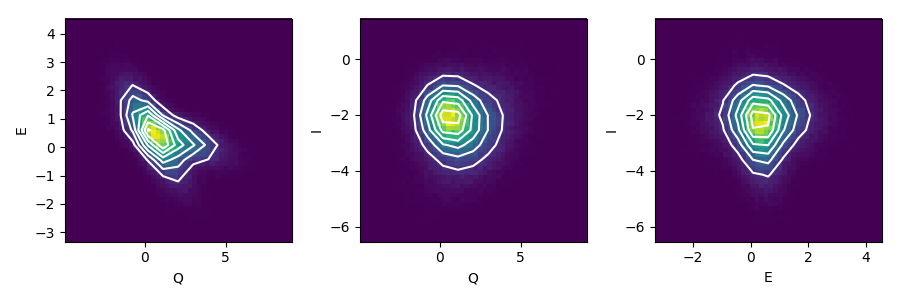

In [73]:
ndata=1000
fig,axs=plt.subplots(1,3,figsize=(9,3))

include=dict(contourf=0,contour=1,data=0,hist=1)

pargs=dict(color='r',ls='None',marker='+',ms=2,alpha=0.5)
#hargs=dict(cmap="nipy_spectral")
hargs=dict(cmap="rainbow")
cargs=dict(color='w',ls='None',marker='v',ms=10)
aargs=dict(color='y',ls='-',lw=2)
targs=dict(color='k',ls='None',marker='o',ms=0.1,mec='None',alpha=0.5)
h2args=dict(bins=50)

i=-1

i+=1
levels=np.logspace(np.log10(PXY.min()),np.log10(PXY.max()),1000)
if include["contourf"]:axs[i].contourf(Xxy,Yxy,PXY,levels=levels,**hargs)
#if include["contour"]:axs[i].contour(Xxy,Yxy,PXY,colors='k')
if include["contour"]:axs[i].contour(Xmxy,Ymxy,Hmxy,colors=['w'])
if include["data"]:axs[i].plot(rs[:,0],rs[:,1],**targs)
if include["hist"]:axs[i].hist2d(rs[:,0],rs[:,1],**h2args)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("E")

i+=1
levels=np.logspace(np.log10(PXZ.min()),np.log10(PXZ.max()),100)
if include["contourf"]:axs[i].contourf(Xxz,Zxz,PXZ,levels=levels,**hargs)
#if include["contour"]:axs[i].contour(Xxz,Zxz,PXZ,colors='k')
if include["contour"]:axs[i].contour(Xmxz,Zmxz,Hmxz,colors=['w'])
if include["data"]:axs[i].plot(rs[:,0],rs[:,2],**targs)
if include["hist"]:axs[i].hist2d(rs[:,0],rs[:,2],**h2args)
axs[i].set_xlabel("Q")
axs[i].set_ylabel("I")

i+=1
levels=np.logspace(np.log10(PYZ.min()),np.log10(PYZ.max()),100)
if include["contourf"]:axs[i].contourf(Yyz,Zyz,PYZ,levels=levels,**hargs)
#if include["contour"]:axs[i].contour(Yyz,Zyz,PYZ,colors=['k'])
if include["contour"]:axs[i].contour(Ymyz,Zmyz,Hmyz,colors=['w'])
if include["data"]:axs[i].plot(rs[:,1],rs[:,2],**targs)
if include["hist"]:axs[i].hist2d(rs[:,1],rs[:,2],**h2args)
axs[i].set_xlabel("E")
axs[i].set_ylabel("I")

"""
for ax in axs:
    ax.grid()
    ax.set_xlim((-vmax,vmax))
    ax.set_ylim((-vmax,vmax))
"""
    
fig.tight_layout()

### Transform to cometary elements using Jacobians

In [155]:
rsc=np.zeros_like(rs)
rsc[:,0]=map2Fin(rs[:,0],scale=1)
rsc[:,1]=map2Fin(rs[:,1],scale=1)
rsc[:,2]=map2Fin(rs[:,2],scale=np.pi)

In [156]:
N=15
Hxy,xcs,ycs=np.histogram2d(rsc[:,0],rsc[:,1],bins=N)
xcms=(xcs[1:]+xcs[:-1])/2
ycms=(ycs[1:]+ycs[:-1])/2
Hxz,xcs,zcs=np.histogram2d(rsc[:,0],rsc[:,2],bins=N)
zcms=(zcs[1:]+zcs[:-1])/2

In [159]:
#Jacobians for map from bound to unbound
def calcJacobianMap(epsilon,scales=[]):
    """
    Parameters:
        epsilon: bound elements, numpy array (N)
        scales: scales for the bound elements ()
    
    
    Return:
    
        Jif= [dE_1/de_1,        0,        0,...,        0,
                      0,dE_2/de_2,        0,...,        0,
                      0,        0,dE_2/de_2,...,        0,
                             . . . 
                      0,        0,        0,...,dE_N/de_N]
                      
        where dE/de = (1/s) /[x(1-x)] and x = e/s.
    """
    JEe=np.identity(len(epsilon))
    for i,eps in enumerate(epsilon):
        x=eps/scales[i]
        JEe[i,i]=(1/scales[i])/(x*(1-x))
    return JEe

In [160]:
def fin2inf(epsilon):
    q,e,i=epsilon
    Q=map2Inf(q)
    E=map2Inf(e)
    I=map2Inf(i,scale=np.pi)
    Epsilon=[Q,E,I]
    return Epsilon
epsilon=[0.2,0.6,30.0*DEG]
depsilon=[1e-6]*3
scales=[1,1,np.pi]
fin2inf(epsilon)
J=calcJacobianMap(epsilon,scales=scales)
print(computeJacobian(fin2inf,epsilon,depsilon,N=3))
print(J)
print(np.linalg.inv(J))

[[6.25       0.         0.        ]
 [0.         4.16666667 0.        ]
 [0.         0.         2.29183118]]
[[6.25       0.         0.        ]
 [0.         4.16666667 0.        ]
 [0.         0.         2.29183118]]
[[0.16       0.         0.        ]
 [0.         0.24       0.        ]
 [0.         0.         0.43633231]]


In [150]:
Pf=np.zeros((N,N,N))
for i,xc in enumerate(xcms):
    for j,yc in enumerate(ycms):
        for k,zc in enumerate(zcms):
            
            #Infinite
            x=map2Inf(xc)
            y=map2Inf(yc)
            z=map2Inf(zc,scale=np.pi)
            
            Pi=multiNorm([x,y,z],weights,locs,covs)
            
            Jif=calcJacobianMap([xc,yc,zc],[1.0,1.0,np.pi])
            detJif=np.linalg.det(Jif)
            
            Pf[i,j,k]=Pi*np.abs(detJif)
            
            """
            print("Bound:",xc,yc,zc)
            print("Unbound:",x,y,z)
            print("detJif = ",detJif)
            print("P (unbound) = ",Pi)
            print("P (bound) = ",Pf[i,j,k])
            #"""
            #break
        #break
    #break
Ycmxy,Xcmxy=np.meshgrid(ycms,xcms)
Zcmxz,Xcmxz=np.meshgrid(zcms,xcms)
Zcmyz,Ycmyz=np.meshgrid(zcms,ycms)

In [151]:
#Marginals
Hcmxy=np.zeros((N,N))
for i,x in enumerate(xcms):
    for j,y in enumerate(ycms):
        Hcmxy[i,j]=Pf[i,j,:].sum()
        
Hcmxz=np.zeros((N,N))
for i,x in enumerate(xcms):
    for j,z in enumerate(zcms):
        Hcmxz[i,j]=Pf[i,:,j].sum()
        
Hcmyz=np.zeros((N,N))
for i,y in enumerate(ycms):
    for j,z in enumerate(zcms):
        Hcmyz[i,j]=Pf[:,i,j].sum()

<IPython.core.display.Javascript object>


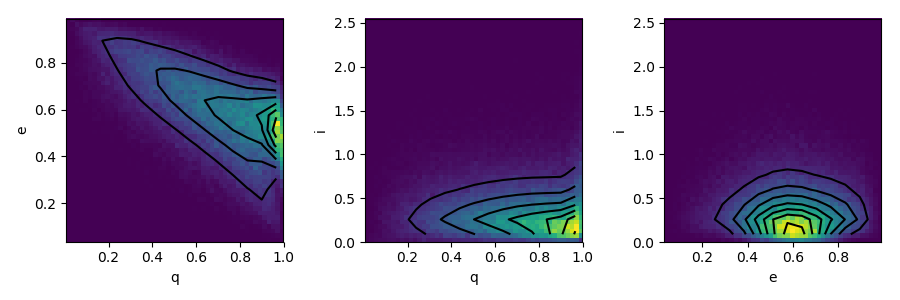

In [154]:
ndata=1000
fig,axs=plt.subplots(1,3,figsize=(9,3))

targs=dict(color='r',ls='None',marker='o',ms=0,mec='None',alpha=0.5)
h2args=dict(bins=50)

i=-1

i+=1
axs[i].plot(rsc[:,0],rsc[:,1],**targs)
axs[i].hist2d(rsc[:,0],rsc[:,1],**h2args)
axs[i].contour(Xcmxy,Ycmxy,Hcmxy,colors="k")
axs[i].set_xlabel("q")
axs[i].set_ylabel("e")

i+=1
axs[i].plot(rsc[:,0],rsc[:,2],**targs)
axs[i].hist2d(rsc[:,0],rsc[:,2],**h2args)
axs[i].contour(Xcmxz,Zcmxz,Hcmxz,colors="k")
axs[i].set_xlabel("q")
axs[i].set_ylabel("i")

i+=1
axs[i].plot(rsc[:,1],rsc[:,2],**targs)
axs[i].hist2d(rsc[:,1],rsc[:,2],**h2args)
axs[i].contour(Ycmyz,Zcmyz,Hcmyz,colors="k")
axs[i].set_xlabel("e")
axs[i].set_ylabel("i")

fig.tight_layout()

In [433]:
np.savetxt("test_elements.data",rs)

In [434]:
rs.shape

(100000, 3)

## Jacobians of orbital elements

I got a package that compute the Jacobians. The package is available here: https://patrius.cnes.fr/index.php.

These are the Jacobians:

```
Jk2c = [da/dx,de/dx,di/dx,dw/dx,dW/dx,dM/dx,
        da/dy,de/dy,di/dy,dw/dy,dW/dy,dM/dy,
        da/dz,de/dz,di/dz,dw/dz,dW/dz,dM/dz,
        da/dx',de/dx',di/dx',dw/dx',dW/dx',dM/dx',
        da/dy',de/dy',di/dy',dw/dy',dW/dy',dM/dy',
        da/dz',de/dz',di/dz',dw/dz',dW/dz',dM/dz']
```

```
Jc2k = [dx/da,dx/de,dx/di,dx/dw,dx/dW,dx/dM,
        dy/da,dy/de,dy/di,dy/dw,dy/dW,dy/dM,
        dz/da,dz/de,dz/di,dz/dw,dz/dW,dz/dM,
        dx'/da,dx'/de,dx'/di,dx'/dw,dx'/dW,dx'/dM,
        dy'/da,dy'/de',dy'/di,dy'/dw,dy'/dW,dy'/dM,
        dz'/da,dz'/de,dz'/di',dz'/dw,dz'/dW,dz'/dM]
```

In [871]:
mu=1
a=0.5
e=0.95
i=45
w=30.0
W=60.0
M=20.0

In [872]:
from os import system,popen
import os
pdir="util/patrius/"
fname=f"GetJacobians"
f=open(f"{pdir}/{fname}.java","w")
f.write(f"""
import fr.cnes.sirius.patrius.orbits.orbitalparameters.CartesianParameters;
import fr.cnes.sirius.patrius.orbits.orbitalparameters.KeplerianParameters;
import fr.cnes.sirius.patrius.orbits.KeplerianOrbit;
import fr.cnes.sirius.patrius.orbits.Orbit;
import fr.cnes.sirius.patrius.time.AbsoluteDate;
import fr.cnes.sirius.patrius.math.util.FastMath;
import fr.cnes.sirius.patrius.orbits.PositionAngle;
import fr.cnes.sirius.patrius.frames.FramesFactory;
import fr.cnes.sirius.patrius.orbits.OrbitType;
import fr.cnes.sirius.patrius.math.linear.RealMatrix;
import fr.cnes.sirius.patrius.math.linear.LUDecomposition;

public class GetJacobians {{

    public static void main(String[] args) {{

        //In canonical units                                                                                                                                                                                                                                  
        double mu={mu}; //UL^3/UT^2                                                                                                                                                                                                                                   
        AbsoluteDate iniDate = AbsoluteDate.J2000_EPOCH.shiftedBy(0);
        double a={a};
        double e={e};
        double i=FastMath.toRadians({i});
        double w=FastMath.toRadians({w});
        double W=FastMath.toRadians({W});
        double M=FastMath.toRadians({M});
        KeplerianParameters kep = new KeplerianParameters(a,e,i,w,W,M,PositionAngle.MEAN,mu);
        CartesianParameters car=kep.getCartesianParameters();
        System.out.println(kep);
        System.out.println(car);
        Orbit initialOrbit = new KeplerianOrbit(kep,FramesFactory.getEME2000(),iniDate);
        RealMatrix Jk2c=initialOrbit.getJacobian(OrbitType.KEPLERIAN,OrbitType.CARTESIAN);
        RealMatrix Jc2k=initialOrbit.getJacobian(OrbitType.CARTESIAN,OrbitType.KEPLERIAN);
        System.out.println(Jk2c);
        System.out.println(Jc2k);
        LUDecomposition Jk2c_desc=new LUDecomposition(Jk2c);
        LUDecomposition Jc2k_desc=new LUDecomposition(Jc2k);
        System.out.println(Jk2c_desc.getDeterminant());
        System.out.println(Jc2k_desc.getDeterminant());
    }}
}}
""")
f.close()
system(f"cd {pdir};javac {fname}.java")
result=popen(f"cd {pdir};java {fname}").read().split("\n")
kepel=result[0]
carel=result[1]
Jk2c=eval(result[2].replace("Array2DRowRealMatrix","np.array(").replace("{","[").replace("}","]")+")")
Jc2k=eval(result[3].replace("Array2DRowRealMatrix","np.array(").replace("{","[").replace("}","]")+")")

In [873]:
kepel

'keplerian parameters: {a: 0.5; e: 0.95; i: 45.0; pa: 30.000000000000004; raan: 60.00000000000001; v: 154.99481775879292;}'

In [874]:
carel

'cartesian parameters: {P(-0.15594535739645055, -0.31327551702856604, -0.021585117406713296), V(-0.3973557015216778, -1.7993915784555385, -0.555575657371409), A(3.618300166324919, 7.268731011262445, 0.5008256430763823)}'

In [875]:
Jc2k

array([[-0.31189071,  0.93004387, -0.01869326,  0.22915073,  0.31327552,
        -0.14048646],
       [-0.62655103, -0.88414585,  0.01079256, -0.09705189, -0.15594536,
        -0.63618099],
       [-0.04317023, -1.24751454, -0.02158512, -0.2469763 , -0.        ,
        -0.19642566],
       [ 0.3973557 ,  2.54201715, -0.48114263,  1.46878764,  1.79939158,
         1.27926229],
       [ 1.79939158,  1.87716839,  0.27778783,  0.05924631, -0.3973557 ,
         2.56988449],
       [ 0.55557566, -1.26286724, -0.55557566, -1.24238426, -0.        ,
         0.1770686 ]])

In [876]:
Jk2c

array([[-1.80915008, -3.63436551, -0.25041282, -0.19867785, -0.89969579,
        -0.27778783],
       [ 0.49705993, -0.34546124, -0.60319714, -0.12690665, -0.04722462,
         0.08629207],
       [ 4.87303199, -2.81344633,  5.62689266, -0.96872075,  0.55929119,
        -1.11858238],
       [-3.36075162,  0.38556784, -1.92924426,  0.51697564, -0.45985775,
        -0.48212025],
       [ 3.08177926, -1.77926609,  3.55853217, -0.11973269,  0.0691277 ,
        -0.1382554 ],
       [ 0.93090174,  2.81718177,  0.60240633,  0.30609075,  1.01440452,
         0.2421199 ]])

In [877]:
np.linalg.inv(Jc2k)

array([[-1.80915008, -3.63436551, -0.25041282, -0.19867785, -0.89969579,
        -0.27778783],
       [ 0.49705993, -0.34546124, -0.60319714, -0.12690665, -0.04722462,
         0.08629207],
       [ 4.87303198, -2.81344633,  5.62689266, -0.96872075,  0.55929119,
        -1.11858238],
       [-3.36075162,  0.38556784, -1.92924426,  0.51697564, -0.45985775,
        -0.48212025],
       [ 3.08177926, -1.77926609,  3.55853217, -0.11973269,  0.0691277 ,
        -0.1382554 ],
       [ 0.93090174,  2.81718177,  0.60240633,  0.30609075,  1.01440452,
         0.2421199 ]])

In [878]:
## Interesting solution to Kepler Problem with NUMBA: 
#https://anhiga-poliastro.readthedocs.io/en/rtd_fix/examples/Quickly%20solving%20Kepler's%20Problem%20in%20Python%20using%20numba.html

In [879]:
#Special variables
x,y,z,vx,vy,vz=spy.conics([a*(1-e),e,i*DEG,W*DEG,w*DEG,M*DEG,0,1],0)
n=np.sqrt(mu/a**3)
tau=M*DEG/n
sinPhi=e
cos2Phi=1-sinPhi**2
E,cosE,sinE=Ecs(M*DEG,e)
r=a*(1-e*cosE)
miu=cosE/cos2Phi
l=-(sinPhi+cosE)/cos2Phi
m=a**1.5*sinE*(l*sinPhi+2/cos2Phi)
lamb=(a**(0.5)/(r**1))*(1/cos2Phi)*sinE*(r**2-a*r-a**2*cos2Phi)
sini=np.sin(i*DEG)
cosi=np.cos(i*DEG)
sinW=np.sin(W*DEG)
cosW=np.cos(W*DEG)
sinw=np.sin(w*DEG)
cosw=np.cos(w*DEG)
cosf=(cosE-e)/(1-e*cosE)
A=Jc2k[3,1]
B=Jc2k[4,1]
miu0=(B-y*A/x)/(vy-vx*y/x)
lamb0=(A-miu*vx)/x
lamb,lamb0
r,np.sqrt(x**2+y**2+z**2)

(0.3506086431598615, 0.35060864415539367)

In [1003]:
lamb0/lamb

16.269895218106925

In [1004]:
np.log10(lamb0/lamb)/np.log10(a)

-4.024133054637551

In [1005]:
sinE,(x*vx+y*vy+z*vz)/(e*np.sqrt(a))

(0.9492547827984651, 0.9492547834928663)

In [1006]:
#Auxiliary variables
TTR3=3*tau/r**3
UOA=1/a
AOR=a**0.5/r
A15=a**1.5
OFT=1.5*tau

In [880]:
#d/dw: CHECKED
-y*cosi-z*sini*cosW,x*cosi-z*sini*sinW,sini*(x*cosW+y*sinW),\
-vy*cosi-vz*sini*cosW,vx*cosi-vz*sini*sinW,sini*(vx*cosW+vy*sinW),Jc2k[:,3]

(0.229150733916118,
 -0.09705188878846109,
 -0.24697630126143702,
 1.4687876445306254,
 0.059246307428705236,
 -1.2423842592138765,
 array([ 0.22915073, -0.09705189, -0.2469763 ,  1.46878764,  0.05924631,
        -1.24238426]))

In [1008]:
#d/di: CHECKED
z*sinW,-z*cosW,-x*sinW+y*cosW,vz*sinW,-vz*cosW,-vx*sinW+vy*cosW,Jc2k[:,2]

(-0.01869326001788345,
 0.010792558703356681,
 -0.021585117406713344,
 -0.4811426330078792,
 0.27778782868570445,
 -0.555575657371409,
 array([-0.01869326,  0.01079256, -0.02158512, -0.48114263,  0.27778783,
        -0.55557566]))

In [1009]:
#d/dW: CHECKED
-y,x,0,-vy,vx,0,Jc2k[:,4]

(0.31327551702856576,
 -0.15594535739645043,
 0,
 1.7993915784555383,
 -0.3973557015216784,
 0,
 array([ 0.31327552, -0.15594536, -0.        ,  1.79939158, -0.3973557 ,
        -0.        ]))

In [1010]:
#d/da: FAILED
(1/a)*(x-1.5*tau*vx),(1/a)*(y-1.5*tau*vy),(1/a)*(z-1.5*tau*vz),\
0.5*(1/a)*(3*tau/r**3*x-vx),0.5*(1/a)*(3*tau/r**3*y-vy),0.5*(1/a)*(3*tau/r**3*z-vz),Jc2k[:,0]

(-0.1647736425703498,
 0.039656144525031856,
 0.1625262326025358,
 -0.942284649398188,
 -0.8917851938021457,
 0.37014984707387066,
 array([-0.31189071, -0.62655103, -0.04317023,  0.3973557 ,  1.79939158,
         0.55557566]))

In [1011]:
#d/de: PARTIALLY CHECKED
l*x+m*vx,l*y+m*vy,l*z+m*vz,lamb*x+miu*vx,lamb*y+miu*vy,lamb*z+miu*vz,Jc2k[:,1]

(0.9300438788597343,
 -0.8841458224275787,
 -1.2475145369405354,
 -1.0467383261050087,
 -5.332210908814552,
 -1.7596034728855388,
 array([ 0.93004387, -0.88414585, -1.24751454,  2.54201715,  1.87716839,
        -1.26286724]))

In [1012]:
A=sinw*sini
B=cosw*cosi
t1=-a*A*sinE*cosE/r**2
t2=-a*A*sinE*cosE/r**2
t3=a*B*cosE**2*np.sqrt(1-e**2)/r**2
t5=-a*B*sinE**2*np.sqrt(1-e**2)/r**2
t4=-e*B*cosE/(r*np.sqrt(1-e**2))
np.sqrt(mu*a)*(t1+t2+t3+t4+t5)

-2.2300914971472117

In [1013]:
a

0.5

In [916]:
t1+t2+t3+t4+t5

0.11283552889280428

In [812]:
lamb,miu

(-0.29816542888467945, 0.9354804931533066)

In [873]:
A=Jc2k[3,1]
B=Jc2k[4,1]
miu=(B-y*A/x)/(vy-vx*y/x)
lamb=(A-miu*vx)/x
lamb,miu

(-0.2981654278592746, 0.9354804998346425)

In [799]:
#d/dM: CHECKED
a**1.5*vx,a**1.5*vy,a**1.5*vz,-a**1.5/r**3*x,-a**1.5/r**3*y,-a**1.5/r**3*z,Jc2k[:,5]

(-1.267764041973702,
 -0.7711082549860793,
 0.7123617388606273,
 0.20557482127873164,
 -0.7847304240945222,
 -0.5703982296530884,
 array([-1.26776404, -0.77110826,  0.71236174,  0.20557482, -0.78473042,
        -0.57039823]))

**CONCLUSION**: El fracaso de esta línea y los errores en las fórmulas del Italiano me obligan a tratar de reconstruir el Jacobiano a partir de lo que esta en Patrius, archivo KeplerianOrbits, Linea 436

## Inverse engineering

In [773]:
#da/dx:
f=2*a**2/r**3
g=2*a**2/mu
f*x,f*y,f*z,g*vx,g*vy,g*vz,Jk2c[0,:]

(-0.5035534160967381,
 1.9221891246694254,
 1.3971846128369236,
 -3.1053750170839254,
 -1.8888217611638365,
 1.7449227724902954,
 array([-0.50355342,  1.92218912,  1.39718461, -3.10537502, -1.88882176,
         1.74492277]))

In [786]:
#de/dx
rvec=np.array([x,y,z])
vvec=np.array([vx,vy,vz])
pv=x*vx+y*vy+z*vz
v=spy.vnorm(vvec)
f=np.sqrt(mu*a)
g=2*a**2/r**3
h=2*a**2/mu
v**2*cosE/(mu*r)*rvec+sinE/np.sqrt(mu*a)*vvec-pv*sinE/(2*a)/f*g*rvec,\
sinE/f*rvec+cosE*2*r/mu*vvec-pv/(2*a)*(1/f)*sinE*h*vvec,Jk2c[1,:]

(array([-0.36427164,  0.44991244,  0.54042471]),
 array([-1.81191739, -0.71750258,  1.2104152 ]),
 array([-0.36427164,  0.44991244,  0.54042471, -1.81191739, -0.71750257,
         1.2104152 ]))

In [ ]:
#di/dx
epsilon=np.sqrt(1-e**2)
sqrtRec=1/epsilon
sqrtMuA=np.sqrt(mu*a)
factorI1=-sini*sqrtRec/sqrtMuA
i1=factorI1
i2=-factorI1*

In [ ]:
"""
final double[][] jacobian = new double[6][6];

        final double a = this.parameters.getA();
        final double e = this.parameters.getE();
        final double i = this.parameters.getI();
        final double pa = this.parameters.getPerigeeArgument();

        // compute various intermediate parameters
        final PVCoordinates pvc = this.getPVCoordinates();
        final Vector3D position = pvc.getPosition();
        final Vector3D velocity = pvc.getVelocity();
        final Vector3D momentum = pvc.getMomentum();
        final double v2 = velocity.getNormSq();
        final double r2 = position.getNormSq();
        final double r = MathLib.sqrt(r2);
        final double r3 = r * r2;

        final double px = position.getX();
        final double py = position.getY();
        final double pz = position.getZ();
        final double vx = velocity.getX();
        final double vy = velocity.getY();
        final double vz = velocity.getZ();
        final double mx = momentum.getX();
        final double my = momentum.getY();
        final double mz = momentum.getZ();

        final double mu = this.getMu();
        final double sqrtMuA = MathLib.sqrt(a * mu);
        final double sqrtAoMu = MathLib.sqrt(a / mu);
        final double a2 = a * a;
        final double twoA = 2 * a;
        final double rOnA = r / a;

        final double oMe2 = 1 - e * e;
        final double epsilon = MathLib.sqrt(MathLib.max(0.0, oMe2));
        final double sqrtRec = 1 / epsilon;

        final double cosI = MathLib.cos(i);
        final double sinI = MathLib.sin(i);
        final double cosPA = MathLib.cos(pa);
        final double sinPA = MathLib.sin(pa);

        final double pv = Vector3D.dotProduct(position, velocity);
        final double cosE = (a - r) / (a * e);
        final double sinE = pv / (e * sqrtMuA);

        // da
        final Vector3D vectorAR = new Vector3D(2 * a2 / r3, position);
        final Vector3D vectorARDot = velocity.scalarMultiply(2 * a2 / mu);
        fillHalfRow(1, vectorAR, jacobian[0], 0);
        fillHalfRow(1, vectorARDot, jacobian[0], 3);

        // de
        final double factorER3 = pv / twoA;
	System.out.println("factorER3 ="+factorER3);
        final Vector3D vectorER = new Vector3D(cosE * v2 / (r * mu), position, sinE / sqrtMuA,velocity,-factorER3 * sinE / sqrtMuA, vectorAR);
	System.out.println("vectorER ="+vectorER);
        final Vector3D vectorERDot = new Vector3D(sinE / sqrtMuA, position, cosE * 2 * r / mu, velocity, -factorER3 * sinE / sqrtMuA, vectorARDot);
        fillHalfRow(1, vectorER, jacobian[1], 0);
	System.out.println("vectorERDot ="+vectorERDot);
        fillHalfRow(1, vectorERDot, jacobian[1], 3);

        // dE / dr (Eccentric anomaly)
        final double coefE = cosE / (e * sqrtMuA);
        final Vector3D vectorEAnR = new Vector3D(-sinE * v2 / (e * r * mu), position, coefE,
            velocity, -factorER3 * coefE, vectorAR);

        // dE / drDot
        final Vector3D vectorEAnRDot = new Vector3D(-sinE * 2 * r / (e * mu), velocity, coefE,
            position, -factorER3 * coefE, vectorARDot);

        // precomputing some more factors
        final double s1 = -sinE * pz / r - cosE * vz * sqrtAoMu;
        final double s2 = -cosE * pz / r3;
        final double s3 = -sinE * vz / (2 * sqrtMuA);
        final double t1 = sqrtRec * (cosE * pz / r - sinE * vz * sqrtAoMu);
        final double t2 = sqrtRec * (-sinE * pz / r3);
        final double t3 = sqrtRec * (cosE - e) * vz / (2 * sqrtMuA);
        final double t4 = sqrtRec * (e * sinI * cosPA * sqrtRec - vz * sqrtAoMu);
        final Vector3D s = new Vector3D(cosE / r, Vector3D.PLUS_K, s1, vectorEAnR, s2, position,
            s3, vectorAR);
        final Vector3D sDot = new Vector3D(-sinE * sqrtAoMu, Vector3D.PLUS_K, s1, vectorEAnRDot,
            s3, vectorARDot);
        final Vector3D t = new Vector3D(sqrtRec * sinE / r, Vector3D.PLUS_K).add(new Vector3D(t1,
            vectorEAnR, t2, position, t3, vectorAR, t4, vectorER));
        final Vector3D tDot = new Vector3D(sqrtRec * (cosE - e) * sqrtAoMu, Vector3D.PLUS_K, t1,
            vectorEAnRDot, t3, vectorARDot, t4, vectorERDot);

        // di
        final double factorI1 = -sinI * sqrtRec / sqrtMuA;
        final double i1 = factorI1;
        final double i2 = -factorI1 * mz / twoA;
        final double i3 = factorI1 * mz * e / oMe2;
        final double i4 = cosI * sinPA;
        final double i5 = cosI * cosPA;
        fillHalfRow(i1, new Vector3D(vy, -vx, 0), i2, vectorAR, i3, vectorER, i4, s, i5, t,
            jacobian[2], 0);
        fillHalfRow(i1, new Vector3D(-py, px, 0), i2, vectorARDot, i3, vectorERDot, i4, sDot, i5,
            tDot, jacobian[2], 3);

        // dpa
        fillHalfRow(cosPA / sinI, s, -sinPA / sinI, t, jacobian[3], 0);
        fillHalfRow(cosPA / sinI, sDot, -sinPA / sinI, tDot, jacobian[3], 3);

        // dRaan
        final double factorRaanR = 1 / (mu * a * oMe2 * sinI * sinI);
        fillHalfRow(-factorRaanR * my, new Vector3D(0, vz, -vy), factorRaanR * mx, new Vector3D(
            -vz, 0, vx), jacobian[4], 0);
        fillHalfRow(-factorRaanR * my, new Vector3D(0, -pz, py), factorRaanR * mx, new Vector3D(pz,
            0, -px), jacobian[4], 3);

        // dM
        fillHalfRow(rOnA, vectorEAnR, -sinE, vectorER, jacobian[5], 0);
        fillHalfRow(rOnA, vectorEAnRDot, -sinE, vectorERDot, jacobian[5], 3);
"""

In [4]:
"""
Taken from: https://github.com/mzechmeister/ke
https://arxiv.org/pdf/1808.07062.pdf
"""
from math import pi, cos, sin, floor
divtwopi = 1 / (2*pi)
acs = [(a, cos(a), sin(a)) for a in \
        [pi/2**i for i in range(1,60)]]
def Ecs(M, e, n=29):
   '''
   Compute the eccentric anomaly and its cos and sin-value CORDIC-like.
   
   Parameters
   ----------
   M : float
      Mean anomaly.
   e : float
      Eccentricity.
   n : integer
      Number of iterations.
   
   Example
   -------
   >>> Ecs(2-sin(2), 1)
   (1.99999999538762, -0.4161468323531165, 0.9092974287451092)
   '''
   E =2* pi*floor(M*divtwopi+0.5)
   cosE, sinE = 1., 0.
   for a,cosa,sina in acs[:n]:
      if E-e*sinE > M:
         a, sina = -a, -sina
      E += a
      cosE, sinE = cosE*cosa - sinE*sina,\
                   cosE*sina + sinE*cosa
   return E, cosE, sinE

In [5]:
%timeit -n 1000 Ecs(10.0*DEG,0.5)

1000 loops, best of 3: 12.2 µs per loop


## Testing Jacobian calculation with Java Package

These are the Jacobians:

```
Jk2c = [da/dx,de/dx,di/dx,dw/dx,dW/dx,dM/dx,
        da/dy,de/dy,di/dy,dw/dy,dW/dy,dM/dy,
        da/dz,de/dz,di/dz,dw/dz,dW/dz,dM/dz,
        da/dx',de/dx',di/dx',dw/dx',dW/dx',dM/dx',
        da/dy',de/dy',di/dy',dw/dy',dW/dy',dM/dy',
        da/dz',de/dz',di/dz',dw/dz',dW/dz',dM/dz']
```

```
Jc2k = [dx/da,dx/de,dx/di,dx/dw,dx/dW,dx/dM,
        dy/da,dy/de,dy/di,dy/dw,dy/dW,dy/dM,
        dz/da,dz/de,dz/di,dz/dw,dz/dW,dz/dM,
        dx'/da,dx'/de,dx'/di,dx'/dw,dx'/dW,dx'/dM,
        dy'/da,dy'/de',dy'/di,dy'/dw,dy'/dW,dy'/dM,
        dz'/da,dz'/de,dz'/di',dz'/dw,dz'/dW,dz'/dM]
```

In [11]:
def externalJacobians(elem):
    from os import system,popen
    pdir="util/patrius/"
    fname=f"GetJacobians"
    f=open(f"{pdir}/{fname}.java","w")
    f.write(f"""
    import fr.cnes.sirius.patrius.orbits.orbitalparameters.CartesianParameters;
    import fr.cnes.sirius.patrius.orbits.orbitalparameters.KeplerianParameters;
    import fr.cnes.sirius.patrius.orbits.KeplerianOrbit;
    import fr.cnes.sirius.patrius.orbits.Orbit;
    import fr.cnes.sirius.patrius.time.AbsoluteDate;
    import fr.cnes.sirius.patrius.math.util.FastMath;
    import fr.cnes.sirius.patrius.orbits.PositionAngle;
    import fr.cnes.sirius.patrius.frames.FramesFactory;
    import fr.cnes.sirius.patrius.orbits.OrbitType;
    import fr.cnes.sirius.patrius.math.linear.RealMatrix;
    import fr.cnes.sirius.patrius.math.linear.LUDecomposition;

    public class GetJacobians {{

        public static void main(String[] args) {{

            //In canonical units                                                                                                                                                                                                                                  
            double mu={elem['mu']}; //UL^3/UT^2                                                                                                                                                                                                                                   
            AbsoluteDate iniDate = AbsoluteDate.J2000_EPOCH.shiftedBy(0);
            double a={elem['a']};
            double e={elem['e']};
            double i=FastMath.toRadians({elem['i']});
            double w=FastMath.toRadians({elem['w']});
            double W=FastMath.toRadians({elem['W']});
            double M=FastMath.toRadians({elem['M']});
            KeplerianParameters kep = new KeplerianParameters(a,e,i,w,W,M,PositionAngle.MEAN,mu);
            CartesianParameters car=kep.getCartesianParameters();
            System.out.println(kep);
            System.out.println(car);
            Orbit initialOrbit = new KeplerianOrbit(kep,FramesFactory.getEME2000(),iniDate);
            RealMatrix Jk2c=initialOrbit.getJacobian(OrbitType.KEPLERIAN,OrbitType.CARTESIAN);
            RealMatrix Jc2k=initialOrbit.getJacobian(OrbitType.CARTESIAN,OrbitType.KEPLERIAN);
            System.out.println(Jk2c);
            System.out.println(Jc2k);
            LUDecomposition Jk2c_desc=new LUDecomposition(Jk2c);
            LUDecomposition Jc2k_desc=new LUDecomposition(Jc2k);
            System.out.println(Jk2c_desc.getDeterminant());
            System.out.println(Jc2k_desc.getDeterminant());
        }}
    }}
    """)
    f.close()
    system(f"cd {pdir};javac {fname}.java")
    result=popen(f"cd {pdir};java {fname}").read().split("\n")
    kepel=result[0]
    carel=result[1]
    Jk2c=eval(result[2].replace("Array2DRowRealMatrix","np.array(").replace("{","[").replace("}","]")+")")
    Jc2k=eval(result[3].replace("Array2DRowRealMatrix","np.array(").replace("{","[").replace("}","]")+")")
    return dict(kepel=kepel,carel=carel,Jk2c=Jk2c,Jc2k=Jc2k)

In [90]:
elements=dict(
    mu=1,
    a=-0.5,
    e=1.95,
    i=45,
    w=30.0,
    W=60.0,
    M=20.0,
    To=0.0,
)
elements['q']=elements['a']*(1-elements['e'])

In [265]:
extJac=externalJacobians(elements)
extJac

{'Jc2k': array([[ 0.35737362,  0.14043378,  0.29551339, -0.38436843, -0.37296431,
         -0.66859134],
        [-0.74592862,  0.53057849, -0.17061474, -0.33531018, -0.17868681,
         -0.26065331],
        [-0.68245894,  0.14367003,  0.34122947,  0.16521774, -0.        ,
          0.44869042],
        [-1.89106187,  0.45275316,  1.09906259,  0.0726162 ,  0.7372389 ,
          0.40988421],
        [-0.7372389 ,  0.83133578, -0.63454408, -2.11433728, -1.89106187,
         -0.85553143],
        [ 1.26908817,  0.02357215,  1.26908817, -1.12005612,  0.        ,
         -0.78273586]]),
 'Jk2c': array([[-0.57966381,  1.20990415,  1.10695566, -0.94553093, -0.36861945,
          0.63454408],
        [-0.92124401,  4.30585887,  2.95075015, -1.82555802, -0.93687122,
          1.11254401],
        [ 0.8194314 , -0.47309894,  0.94619788,  0.12087305, -0.06978609,
          0.13957218],
        [ 1.47814904,  0.47327346,  1.10071562, -0.42014313, -0.50004203,
         -0.46269215],
        [-1.

In [92]:
elements['q']=elements['a']*(1-elements['e'])
velements=np.array([elements[e] for e in ['q','e','i','W','w','M','To','mu']])
velements[2:6]*=DEG
x=spy.conics(velements,0)
x

array([-0.17868681,  0.37296431,  0.34122947, -1.89106187, -0.7372389 ,
        1.26908817])

In [93]:
r=spy.vnorm(x[:3])

In [94]:
-x[:3]*elements["mu"]/r**3

array([ 1.15932762, -2.41980831, -2.21391133])

In [109]:
xfunW=lambda x:spy.conics([elements['a']*(1-elements['e']),
                          elements['e'],
                          elements['i']*DEG,
                          x*DEG,#elements['W']*DEG,
                          elements['w']*DEG,
                          elements['M']*DEG,
                          elements['To'],
                          elements['mu']],0)[0]

In [110]:
elements['W']

60.0

In [111]:
xfun(60.0)

-0.1786868098317756

In [99]:
#dx/de
ex=1.95
dex=0.01
dxde=(xfun(ex+dex)-xfun(ex-dex))/(2*dex)
dxde

0.1404363421507765

In [113]:
#dx/dW
Wx=60.0
dWx=0.01
dxdW=(xfunW(Wx+dWx)-xfun(Wx-dWx))/(2*(dWx*DEG))
dxdW

-0.3729643080309467

### Numerical jacobian

Here we compute the general Jacobian matrix of a numerical N-dimensional function returning N-dimensional vector

In [295]:
NEVAL=0
def elements2state(x,**args):
    """
        x: a,e,i,w,W,M
        y: x,y,z,vx,vy,vz
    """
    global NEVAL
    To=args["To"]
    mu=args["mu"]
    q=x[0]*(1-x[1])
    y=spy.conics([q,x[1],x[2],x[4],x[3],x[5],To,mu],0)
    NEVAL+=1
    return y

def state2elements(x,**args):
    """
        x: x,y,z,vx,vy,vz
        y: a,e,i,w,W,M
    """
    global NEVAL
    To=args["To"]
    mu=args["mu"]
    q,e,i,W,w,M,To,mu=spy.oscelt(x,To,mu)
    a=q/(1-e)
    NEVAL+=1
    return [a,e,i,w,W,M]

In [296]:
elements

{'M': 20.0,
 'To': 0.0,
 'W': 60.0,
 'a': -0.5,
 'e': 1.95,
 'i': 45,
 'mu': 1,
 'q': 0.475,
 'w': 30.0}

In [341]:
x=[elements['a'],elements['e'],elements['i']*DEG,elements['w']*DEG,elements['W']*DEG,elements['M']*DEG]
print(x)
dx=[0.01]*6
dy=[0.01]*6
y=elements2state(x,mu=elements['mu'],To=elements['To'])
print(y)

[-0.5, 1.95, 0.7853981633974483, 0.5235987755982988, 1.0471975511965976, 0.3490658503988659]
[-0.17868681  0.37296431  0.34122947 -1.89106187 -0.7372389   1.26908817]


In [342]:
state2elements(y,mu=elements['mu'],To=elements['To'])

[-0.4999999999999996,
 1.9500000000000006,
 0.7853981633974482,
 0.5235987755982989,
 1.0471975511965976,
 0.3490658503988656]

In [39]:
def computeJacobian(jfun,x,dx,N=6,**args):
    variables={}
    J=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            pre=[x[k] for k in range(j)]
            pos=[x[k] for k in range(j+1,N)]
            yi=lambda t:jfun(pre+[t]+pos,**args)[i]
            dyidxj=(yi(x[j]+dx[j])-yi(x[j]-dx[j]))/(2*dx[j])
            J[i,j]=dyidxj
    return J

In [344]:
args=dict(To=0,mu=1)
NEVAL=0
computeJacobian(elements2state,x,dx,**args)
NEVAL

72

In [345]:
extJac['Jc2k']

array([[ 0.35737362,  0.14043378,  0.29551339, -0.38436843, -0.37296431,
        -0.66859134],
       [-0.74592862,  0.53057849, -0.17061474, -0.33531018, -0.17868681,
        -0.26065331],
       [-0.68245894,  0.14367003,  0.34122947,  0.16521774, -0.        ,
         0.44869042],
       [-1.89106187,  0.45275316,  1.09906259,  0.0726162 ,  0.7372389 ,
         0.40988421],
       [-0.7372389 ,  0.83133578, -0.63454408, -2.11433728, -1.89106187,
        -0.85553143],
       [ 1.26908817,  0.02357215,  1.26908817, -1.12005612,  0.        ,
        -0.78273586]])

In [346]:
NEVAL=0
dy=[1e-4]*6
J=computeJacobian(state2elements,y,dy,**args)
J,NEVAL

(array([[-0.57966377,  1.20990425,  1.10695571, -0.94553096, -0.36861945,
          0.63454409],
        [-0.92124398,  4.30585881,  2.95075013, -1.82555802, -0.93687122,
          1.11254401],
        [ 0.81943139, -0.47309896,  0.94619786,  0.12087305, -0.06978609,
          0.13957218],
        [ 1.47814904,  0.47327349,  1.10071564, -0.42014313, -0.50004203,
         -0.46269215],
        [-1.313045  ,  0.7580869 , -1.51617382,  0.35304848, -0.20383264,
          0.40766527],
        [-1.75415419,  0.64705901,  1.84267157, -0.79083128, -0.02348712,
          0.67313642]]), 72)

In [347]:
np.linalg.det(J)

2.05128188028373

In [348]:
extJac['Jk2c']

array([[-0.57966381,  1.20990415,  1.10695566, -0.94553093, -0.36861945,
         0.63454408],
       [-0.92124401,  4.30585887,  2.95075015, -1.82555802, -0.93687122,
         1.11254401],
       [ 0.8194314 , -0.47309894,  0.94619788,  0.12087305, -0.06978609,
         0.13957218],
       [ 1.47814904,  0.47327346,  1.10071562, -0.42014313, -0.50004203,
        -0.46269215],
       [-1.313045  ,  0.75808689, -1.51617377,  0.35304848, -0.20383264,
         0.40766527],
       [-1.75415418,  0.64705902,  1.84267159, -0.79083129, -0.02348712,
         0.67313642]])

In [349]:
np.linalg.det(extJac['Jk2c'])

2.0512820511223118

In [350]:
NEVAL=0
%timeit -n 100 computeJacobian(elements2state,x,dx,**args)
NEVAL/(3*100)

100 loops, best of 3: 1.82 ms per loop


72.0

In [352]:
%timeit -n 100 spy.conics(velements,0)

100 loops, best of 3: 27 µs per loop


In [9]:
GLOBAL_OBS=None
#Phsyical
ELEV=80.0 #km, Reference elevation
AU=1.4959787070000000e8 #km, value assumed in DE430
RMOON=3.84e5 #km
MUSUN=132712440040.944000 #km^3/s^2
MUEARTH=398600.436233 #km^3/s^2
MUMOON=4902.800076 #km^3/s^2
MUEARTHMOON=403503.236310 #km^3/s^2
RHILLEARTH=AU*(MUEARTH/(3*MUSUN))**(1./3)
RHILLMOON=RMOON*(MUMOON/(3*MUEARTH))**(1./3)
DAY=86400
def str2t(date):
    et=spy.str2et(date)
    dt=spy.deltet(et,"ET")
    t=et-dt
    return t
spy.str2t=str2t
#Kernels
kernels=[
    #Time
    "naif0012.tls",
    #Object properties
    "pck00010.tpc",
    #Planetary positions
    #"de421.bsp",
    "de430.bsp",
    #Earth reference system
    #"earth_720101_070426.bpc","earth_070425_370426_predict.bpc","earth_latest_high_prec_20190910.bpc"
    "earth_latest_high_prec_20190910.bpc",
    "moon_pa_de421_1900-2050.bpc",
    "moon_080317.tf"
    ]
for kernel in kernels:spy.furnsh(f"{KERDIR}/{kernel}")
class Observer(object):
    """
    lon: longitude, float, radians
    lat: latitude, float, radians
    alt: elevation over reference ellipsoid, float, km
    objid: SPICE Object string (eg. EARTH), string
    """
    _RF=dict(
        EARTH="ITRF93",
        MOON="IAU_MOON" #Others: MOON_PA, MOON_ME
    )
    _PROT=dict(EARTH=DAY,MOON=27.321661*DAY)
    
    def __init__(self,lon,lat,alt,objid):
        self.lon=lon
        self.lat=lat
        self.alt=alt
        self.objid=objid
        radii=spy.bodvrd(self.objid,"RADII",3)[1]
        self._RE=radii[0]
        self._RP=radii[2]
        self._FE=(self._RE-self._RP)/self._RE
        self._positionBody=spy.georec(lon,lat,alt,self._RE,self._FE) 
        self._rho=((self._positionBody[:2]**2).sum())**0.5 #Distance to Earth's axis
        self._velocityLocal=np.array([0,+2*np.pi*self._rho/self._PROT[self.objid],0]) 
        self._calcMatrices()
        self._velocityBody=spy.mxv(self._loc2bod,self._velocityLocal)
    
    def _calcMatrices(self):
        uz=spy.surfnm(self._RE,self._RE,self._RP,self._positionBody)
        uy=spy.ucrss(np.array([0,0,1]),uz)
        ux=spy.ucrss(uz,uy)
        self._loc2bod=np.array(np.vstack((ux,uy,uz)).transpose().tolist())
        self._bod2loc=np.linalg.inv(self._loc2bod)
        self._bod2ecl=None
        self._ecl2bod=None
        
    def updateOrientationPosition(self,et):
        self._et=et
        self._bod2ecl=spy.pxform(self._RF[self.objid],"ECLIPJ2000",et)
        self._ecl2bod=np.linalg.inv(self._bod2ecl)
        self._stateBody=spy.spkezr(self.objid,et,"ECLIPJ2000","NONE","SSB")[0]
        self._positionEcl=spy.mxv(self._bod2ecl,self._positionBody)
        self._positionEcl=self._positionEcl+self._stateBody[:3]
        
    def _checkOrientation(self):
        if self._ecl2bod is None:
            raise AssertionError("You must update orientation, eg. observer.updateOrientation(et)")
        
    def ecl2loc(self,eclon,eclat):
        """
        Parameters:
            eclon: Ecliptic longitude, float, radians
            eclat: Ecliptic latitude, float, radians
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        """
        self._checkOrientation()
        ecx,ecy,ecz=spy.latrec(1,eclon,eclat)
        x,y,z=spy.mxv(self._bod2loc,spy.mxv(self._ecl2bod,[ecx,ecy,ecz]))
        r,A,h=spy.reclat([x,y,z])
        A=2*np.pi+A if A<0 else A
        return A,h

    def loc2ecl(self,A,h):
        """
        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
        Return:
            eclon: Ecliptic longitude (0,2pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
        """
        self._checkOrientation()
        x,y,z=spy.latrec(1,A,h)
        ecx,ecy,ecz=spy.mxv(self._bod2ecl,spy.mxv(self._loc2bod,[x,y,z]))
        r,eclon,eclat=spy.reclat([ecx,ecy,ecz])
        eclon=2*np.pi+eclon if eclon<0 else eclon
        return eclon,eclat

    def vBod2vloc(self,vBod):
        """
        Parameters:
            vBod: Velocity in the body-fixed system, np.array, km/s
        Return:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        """
        vLoc=spy.mxv(self._bod2loc,vBod)
        vloc,A,h=spy.reclat(vLoc)
        A=2*np.pi+A if A<0 else A
        return A,h,vloc
    
    def vloc2vBod(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the rotating geocentric reference frame) 
        of a particle GOING to A,h at a speed vloc. 
        
        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vBod: Velocity in the body-fixed system, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)
        vBod=spy.mxv(self._loc2bod,vLoc)
        return vBod
    
    def vloc2vRot(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the non-rotating geocentric reference frame) 
        of a particle GOING from A,h at a speed vloc

        It is VERY important to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vRot: Velocity in the inertial system, body axes, np.array, km/s
        """
        self._checkOrientation()
        vLoc=spy.latrec(vloc,A,h)+self._velocityLocal
        vRot=spy.mxv(self._loc2bod,vLoc)
        return vRot
        
    def vloc2vEcl(self,A,h,vloc):
        """
        Answer the question: what is the velocity (in the heliocentric reference frame) 
        of a particle GOING from A,h to a speed vloc

        It is VERY importante to take into account that if a particle is COMING from A,h, you 
        need to specify its velocity as (A,h,-vloc) or (360-A,h,vloc).

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            vEcl: Velocity in the inertial ecliptic system, np.array, km/s
        """
        vRot=self.vloc2vRot(A,h,vloc)
        vEcl=spy.mxv(self._bod2ecl,vRot)+self._stateBody[3:]
        return vEcl

    def helioState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            bodyState: State vector with respect to sun, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        vEcl=self.vloc2vEcl(A,h,vloc)
        state=np.concatenate((self._positionEcl,vEcl))
        return state

    def bodyState(self,A,h,vloc):
        """
        Answer the question: what is the heliocentric state of a particle COMING from A,h to a speed vloc

        Parameters:
            A: Azimuth (0,2 pi), float, radians
            h: Elevation (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (-infty,infty), float, km/s
        Return:
            bodyState: State vector with respect to geocenter, np.array (6), (km,km,km,km/s,km/s,km/s)
        """
        return self.helioState(A,h,vloc)-self._stateBody

    
    def vecl2vEcl(self,eclon,eclat,vloc):
        """
        Parameters:
            eclon: Ecliptic longitude (0,2 pi), float, radians
            eclat: Ecliptic latitude (-pi,pi), float, radians
            vloc: Impact speed in the local reference frame, (0,infty), float, km/s
        Return:
            vEcl: Velocity in the ecliptic system, np.array, km/s
        """
        self._checkOrientation()
        A,h=self.ecl2loc(eclon,eclat)
        vEcl=self.vloc2vEcl(vloc,A,h)
        return vEcl
    
from copy import deepcopy
def rayOscelt(lon,lat,alt,objid,A,h,vimp,et,objects=["EARTH"],mus=[MUEARTH],rhill=[1e6],simple=True,globalobs=True):
    """
    Compute the orbital elements of a particle impacting on lon, lat, alt at time et
    going towards A, h at speed vimp.
    
    Parameters:
        lon: Longitude, float, degrees
        lat: Latitude, float, degrees
        alt: Altitude, float, km
        A: Azimuth, float, degrees
        h: Elevation, float, degrees
        vimp: Impact speed, float (negative), km/s
        et: Time of impact (TDB), float, seconds
    Options:
        objects:
    """
    #Prepare observer structure
    global GLOBAL_OBS
    if globalobs:
        if (GLOBAL_OBS is None) or \
                np.isclose([lon,lat,alt],[GLOBAL_OBS.lon*RAD,GLOBAL_OBS.lat*RAD,GLOBAL_OBS.alt],rtol=1e-5).sum()<3:
            obs=Observer(lon*DEG,lat*DEG,alt,objid)
            obs.updateOrientationPosition(et)
            GLOBAL_OBS=deepcopy(obs)
        else:
            obs=GLOBAL_OBS
            if np.isclose(et,GLOBAL_OBS._et,rtol=1e-10)==False:
                obs.updateOrientationPosition(et)
    else:
        obs=Observer(lon*DEG,lat*DEG,alt,objid)
        obs.updateOrientationPosition(et)
        
                
    #Simple estimation
    if simple:
        heliostate=obs.helioState(A*DEG,h*DEG,vimp)
        E_sim=spy.oscelt(heliostate,et,MUSUN)
    
    E_pcon=[]

    #State respect to the central body
    state=obs.bodyState(A*DEG,h*DEG,vimp)+obs._stateBody
    for k,objid in enumerate(objects):
        #State respect to object objid
        bodypos=spy.spkezr(objid,et,"ECLIPJ2000","NONE","SSB")[0]
        state=state-bodypos
        #Get object-centric elements
        rt=spy.vnorm(state[:3])
        q,e,i,Omega,omega,Mo,eto,mu=spy.oscelt(state,et,mus[k])
        a=q/(1-e)
        n=np.sqrt(mu/np.abs(a)**3)
        etp=eto-Mo/n
        #hill
        fd=np.arccos((q*(1+e)/rhill[k]-1)/e)
        #See: https://space.stackexchange.com/questions/27602/what-is-hyperbolic-eccentric-anomaly-f
        Hd=2*np.arctanh(np.sqrt((e-1)/(e+1))*np.tan(fd/2))
        Md=e*np.sinh(Hd)-Hd
        deltat=Md/n
        #Body position
        bodypos=spy.spkezr(objid,etp-deltat,"ECLIPJ2000","NONE","SSB")[0]
        #Heliocentric conic:
        bodyStatet=spy.conics([q,e,i,Omega,omega,Mo,eto,mus[k]],etp-deltat)
        hillstate=bodyStatet+bodypos
        #Final orbit
        E_pcon+=[spy.oscelt(hillstate,etp-deltat,MUSUN)]
        #Next state
        et=etp-deltat
        state=hillstate
    if simple:
        return E_sim,E_pcon 
    else:
        return E_pcon 

In [418]:
et=spy.str2t("02/15/2013 03:20:34 UTC")
Esim,Epcon=rayOscelt(63.5,54.4,80.0,"EARTH",96.0,17.0,-19.0,et)
Epcon[0]

array([1.17214222e+08, 6.32312919e-01, 8.50833093e-02, 5.69977866e+00,
       2.05721967e+00, 2.18531360e-01, 4.14104782e+08, 1.32712440e+11])

In [409]:
%timeit -n 100 Epcon=rayOscelt(63.5,54.4,80.0,"EARTH",96.0,17.0,-19.0,et,simple=False,globalobs=0)

100 loops, best of 3: 660 µs per loop


In [510]:
def local2elements(x,**args):
    lon,lat,alt,vimp,A,h=x
    lon*=RAD
    lat*=RAD
    alt*=100
    vimp*=11
    A*=RAD
    h*=RAD
    Epcon=rayOscelt(lon,lat,alt,args["objid"],A,h,vimp,args["et"],simple=False,globalobs=False)
    E=Epcon[0]
    E[0]/=AU
    #Map to infinite
    #"""
    E[0]=map2Inf(E[0],scale=1)
    E[1]=map2Inf(E[1],scale=1)
    E[2]=map2Inf(E[2],scale=2*np.pi)
    E[3]=map2Inf(E[3],scale=2*np.pi)
    E[4]=map2Inf(E[4],scale=2*np.pi)
    E[5]=map2Inf(E[5],scale=2*np.pi)
    #"""
    return E[:6]

In [538]:
x=[63.5*DEG,54.4*DEG,80.0/100.0,-19.0/11.0,96.0*DEG,17.0*DEG]
dx=[1e-6]*6
et=spy.str2t("02/15/2013 03:20:34 UTC")
args=dict(objid="EARTH",et=et)
local2elements(x,**args)

array([ 1.28634961,  0.54215215, -4.28836751,  2.27929817, -0.71989239,
       -3.32330324])

In [539]:
J=computeJacobian(local2elements,x,dx,**args)
J

array([[ 1.95685297e+00,  2.79786108e-01, -3.87128840e-03,
         7.94998521e-01, -2.28290773e+00, -2.33168677e-01],
       [ 2.47706751e+00,  3.39047379e-01,  8.68809774e-03,
        -2.46116091e+00, -2.43097076e+00, -1.01338432e+00],
       [-2.35818406e+00,  6.77336569e-01,  1.91412668e-02,
        -1.98085205e+00, -7.59929593e-01,  6.09368130e+00],
       [-7.54802221e-04,  3.65701691e-04,  1.74642523e-05,
         1.25949473e-04, -2.55689692e-04,  1.79565030e-03],
       [ 9.52771199e-01,  1.34481663e-01, -5.58863178e-04,
         4.69441044e-02, -1.06603964e+00, -1.84649180e-01],
       [-4.22890150e+00, -5.85965964e-01, -7.75055931e-03,
         2.39644859e+00,  4.38663731e+00,  1.36018712e+00]])

In [542]:
Ji=np.linalg.inv(J)

In [543]:
Ji

array([[ 1.89807503e+04,  5.21717276e+04, -3.08406907e+01,
         1.16118638e+04,  3.22611624e+04,  4.66257960e+04],
       [ 1.31036190e+04,  2.23877432e+04, -1.24856377e+01,
        -1.19687185e+03, -2.24257284e+03,  1.86789631e+04],
       [-5.80823747e+04,  9.22175701e+03, -3.29519165e+01,
         1.45880795e+05,  2.04937045e+05,  2.46896167e+04],
       [ 2.73509626e+02,  1.04163961e+03, -7.44448843e-01,
         6.51614336e+02,  9.87396995e+02,  9.59458832e+02],
       [ 1.72205580e+04,  4.53934384e+04, -2.67540496e+01,
         9.22141727e+03,  2.57789735e+04,  4.03788798e+04],
       [ 8.30770498e+03,  2.36719196e+04, -1.38579846e+01,
         5.53025859e+03,  1.56260343e+04,  2.12372979e+04]])

In [546]:
np.linalg.det(Ji)/1e12

0.9418616349615919

In [541]:
%timeit -n 100 computeJacobian(local2elements,x,dx,**args)

100 loops, best of 3: 57.3 ms per loop


### Analytical Jacobians 

In [12]:
def any_geo2bod(lon,lat,alt,R,f):
    a=R
    b=a*(1-f)
    N=a**2/np.sqrt(a**2*np.cos(lat)**2+b**2*np.sin(lat)**2)
    x=(N+alt)*np.cos(lat)*np.cos(lon)
    y=(N+alt)*np.cos(lat)*np.sin(lon)
    z=(b**2*N/a**2+alt)*np.sin(lat)
    return np.array([x,y,z])

def any_loc2vbod(A,h,vimp):
    vx=vimp*np.cos(h)*np.cos(A)
    vy=vimp*np.cos(h)*np.sin(A)
    vz=vimp*np.sin(h)
    return np.array([vx,vy,vz])

def any_loc2bod(lon,lat):
    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    R=np.array([[-slat*clon,-slon,clat*clon],[-slat*slon,clon,clat*slon],[clat,0,slat]])
    return R

def any_vloc2vbod(lon,lat,A,h,v):
    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    sA=np.sin(A);cA=np.cos(A)
    sh=np.sin(h);ch=np.cos(h)
    
    vx=v*(-ch*cA*slat*clon-ch*sA*slon+sh*clat*clon)
    vy=v*(-ch*cA*slat*slon+ch*sA*clon+sh*clat*slon)
    vz=v*(ch*cA*clat+sh*slat)
    
    return np.array([vx,vy,vz])

def any_vloc2vrot(lon,lat,alt,A,h,v,R,f):
    a=R
    b=a*(1-f)

    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    sA=np.sin(A);cA=np.cos(A)
    sh=np.sin(h);ch=np.cos(h)

    N=a**2/np.sqrt(a**2*clat**2+b**2*slat**2)
    x=(N+alt)*clat*clon
    y=(N+alt)*clat*slon
    vr=2*np.pi*np.sqrt(x**2+y**2)/DAY
    fr=vr/v
    
    vx=v*(-ch*cA*slat*clon-(ch*sA+fr)*slon+sh*clat*clon)
    vy=v*(-ch*cA*slat*slon+(ch*sA+fr)*clon+sh*clat*slon)
    vz=v*(ch*cA*clat+sh*slat)
    
    return np.array([vx,vy,vz])

def Rmat(W,i,w):
    """
    Brings from inertial (x,y,z) to rotated (x''',y''',z''')
    """
    cW=np.cos(W);sW=np.sin(W)
    cw=np.cos(w);sw=np.sin(w)
    ci=np.cos(i);si=np.sin(i)
    
    R1=[cw*cW-ci*sw*sW,cw*sW+cW*ci*sw,si*sw]
    R2=[-cW*sw-sW*ci*cw,-sW*sw+cW*ci*cw,si*cw]
    R3=[sW*si,-cW*si,ci]
    
    R=np.array([R1,R2,R3])
    return R

def Rinv(W,i,w):
    """
    Brings from rotated (x''',y''',z''') to inertial (x,y,z)
    Rinv(W,i,w) = Rmat(-w,-i,-W)
    """
    cW=np.cos(W);sW=np.sin(W)
    cw=np.cos(w);sw=np.sin(w)
    ci=np.cos(i);si=np.sin(i)
    
    R1=[cW*cw-ci*sW*sw,-cW*sw-cw*ci*sW,si*sW]
    R2=[cw*sW+sw*ci*cW,-sw*sW+cw*ci*cW,-si*cW]
    R3=[sw*si,cw*si,ci]
    
    R=np.array([R1,R2,R3])
    return R

radii=spy.bodvrd("EARTH","RADII",3)[1]
R=radii[0]
f=(R-radii[2])/R


In [735]:
lon=25*DEG
lat=53*DEG
alt=100 # km
et=spy.str2et("2000 JAN 01 12:00:00 UTC")
obs=Observer(lon,lat,alt,"EARTH")
obs.updateOrientationPosition(et)
print("SPICE:",obs._positionBody)
print("Analytic:",any_geo2bod(lon,lat,alt,R,f))

SPICE: [3540.8185436  1651.11080302 5150.40671941]
Analytic: [3540.8185436  1651.11080302 5150.40671941]


In [736]:
A=40.0*DEG
h=20.0*DEG
vimp=-10.0 #km/s
print("SPICE body:",obs.vloc2vBod(A,h,vimp))
vloc=any_loc2vbod(A,h,vimp)
vbod=spy.mxv(obs._loc2bod,vloc)
print("Analytic:",vbod)
vbod=any_vloc2vbod(lon,lat,A,h,vimp)
print("Full analytic:",vbod)
print("SPICE rotating:",obs.vloc2vRot(A,h,vimp))
vrot=any_vloc2vrot(lon,lat,alt,A,h,vimp,R,f)
print("Rotating full analytic:",vrot)

SPICE body: [ 5.89786728 -3.91443323 -7.06345341]
Analytic: [ 5.89786728 -3.91443323 -7.06345341]
Full analytic: [ 5.89754787 -3.91458217 -7.06363756]
SPICE rotating: [ 5.77779511 -3.65693764 -7.06345341]
Rotating full analytic: [ 5.77747571 -3.65708658 -7.06363756]


The slight discrepancy is due to the fact that the matricial analytical approach here does not consider the latitude correction due to oblateness that it is properly considered when building the transformation matrix using the normal vector (as I do in the Observer object)

In [689]:
any_loc2bod(lon,lat)

array([[-0.72380958, -0.42261826,  0.54542964],
       [-0.33751795,  0.90630779,  0.25433802],
       [ 0.60181502,  0.        ,  0.79863551]])

In [700]:
obs._loc2bod

array([[-0.72383679, -0.42261826,  0.54539353],
       [-0.33753064,  0.90630779,  0.25432118],
       [ 0.60177518,  0.        ,  0.79866554]])

In [701]:
W=300.0*DEG
w=145.0*DEG
i=50.0*DEG
any_R=Rmat(W,i,w)
any_Rinv=Rinv(W,i,w)
Rspc=spy.eul2m(w,i,W,3,1,3)
print("Analytical:",any_R)
print("SPICE:",Rspc)
print("Analytical inverted:",any_Rinv)
print("SPICE inverted:",np.linalg.inv(Rspc))

Analytical: [[-0.090283    0.89375039  0.43938504]
 [-0.74278591  0.23346137 -0.62750687]
 [-0.66341395 -0.38302222  0.64278761]]
SPICE: [[-0.090283    0.89375039  0.43938504]
 [-0.74278591  0.23346137 -0.62750687]
 [-0.66341395 -0.38302222  0.64278761]]
Analytical inverted: [[-0.090283   -0.74278591 -0.66341395]
 [ 0.89375039  0.23346137 -0.38302222]
 [ 0.43938504 -0.62750687  0.64278761]]
SPICE inverted: [[-0.090283   -0.74278591 -0.66341395]
 [ 0.89375039  0.23346137 -0.38302222]
 [ 0.43938504 -0.62750687  0.64278761]]


### From orbital elements to cartesian coordinates

In [7]:
"""
Taken from: https://github.com/mzechmeister/ke
https://arxiv.org/pdf/1808.07062.pdf
"""
from math import pi, cos, sin, floor
divtwopi = 1 / (2*pi)
acs = [(a, cos(a), sin(a)) for a in \
        [pi/2**i for i in range(1,60)]]
def Ecs(M, e, n=29):
   '''
   Compute the eccentric anomaly and its cos and sin-value CORDIC-like.
   
   Parameters
   ----------
   M : float
      Mean anomaly.
   e : float
      Eccentricity.
   n : integer
      Number of iterations.
   
   Example
   -------
   >>> Ecs(2-sin(2), 1)
   (1.99999999538762, -0.4161468323531165, 0.9092974287451092)
   '''
   E =2* pi*floor(M*divtwopi+0.5)
   cosE, sinE = 1., 0.
   for a,cosa,sina in acs[:n]:
      if E-e*sinE > M:
         a, sina = -a, -sina
      E += a
      cosE, sinE = cosE*cosa - sinE*sina,\
                   cosE*sina + sinE*cosa
   return E, cosE, sinE

# initialise cosh-sinh look-up table
from math import log, cosh, sinh, frexp, ldexp
ln2 = log(2)
acsh = [(a, cosh(a), sinh(a)) for a in \
        [4*ln2/2**i for i in range(1,60)]]

def Hcs(M, e, n=29):
   '''
   Compute the hyperbolic anomaly and its cosh and sinh-value CORDIC-like.
   
   Parameters
   ----------
   M : float
      Mean anomaly.
   e : float
      Eccentricity.
   n : integer
      Number of iterations.
   
   Example
   -------
   >>> Hcs(sinh(2)-2, 1)
   (1.9999999991222275, 3.7621956879000753, 3.626860404544669)
   >>> Hcs(-(sinh(5)-5), 1)
   (-5.000000000387744, 74.20994855355976, -74.20321060656327)
   '''
   m = max(0, frexp(M/e)[1])
   if M < 0: m = -m
   H = m * ln2
   coshH = ldexp(1, m-1) + ldexp(1, -m-1)
   sinhH = ldexp(1, m-1) - ldexp(1, -m-1)
   for a,cosha,sinha in acsh[:n]:
      if e*sinhH-H > M:
         a, sinha = -a, -sinha
      H += a
      coshH, sinhH = coshH*cosha + sinhH*sinha,\
                     coshH*sinha + sinhH*cosha
   return H, coshH, sinhH

In [837]:
def elem2cart(a,e,i,W,w,M,mu):
    cW=np.cos(W);sW=np.sin(W)
    cw=np.cos(w);sw=np.sin(w)
    ci=np.cos(i);si=np.sin(i)
    if e<1:
        print("Elliptic")
        s=1
        E,cE,sE=Ecs(M,e)
    if e>1:
        print("Hyperbolic")
        s=-1
        E,cE,sE=Hcs(M,e)

    #Semimajor axis
    ab=np.abs(a)
    b=ab*np.sqrt(s*(1-e**2))
    nu=np.sqrt(mu*ab)
    r=a*(1-e*cE)
    
    #Coordinates in orbit plane
    xp=a*(cE-e)
    yp=b*sE
    zp=0
    vxp=-nu/r*sE
    vyp=nu/r*np.sqrt(s*(1-e**2))*cE
    vzp=0
    
    #Coordinates in rotating frame
    x=xp*(cW*cw-ci*sW*sw)+yp*(-cW*sw-cw*ci*sW)
    y=xp*(cw*sW+sw*ci*cW)+yp*(-sw*sW+cw*ci*cW)
    z=xp*sw*si+yp*cw*si
    
    vx=vxp*(cW*cw-ci*sW*sw)+vyp*(-cW*sw-cw*ci*sW)
    vy=vxp*(cw*sW+sw*ci*cW)+vyp*(-sw*sW+cw*ci*cW)
    vz=vxp*sw*si+vyp*cw*si
    
    return np.array([xp,yp,zp,vxp,vyp,vzp]),np.array([x,y,z,vx,vy,vz])

In [851]:
q=1.3
e=0.6
a=q/(1-e)
i=30*DEG
W=160*DEG
w=145*DEG
M=180*DEG
mu=1.0

In [845]:
xp,x=elem2cart(a,e,i,W,w,M,mu)
print("In conic system:",xp)
print("In conic system (SPICE):",spy.conics([q,e,0,0,0,M,0,mu],0))

Hyperbolic
In conic system: [-3.64054334  8.45435176  0.         -0.49957919  0.65516059  0.        ]
In conic system (SPICE): [-3.64054331  8.45435173  0.         -0.49957919  0.65516059  0.        ]


In [846]:
print("In inertial frame:",x)
print("In inertial fram (SPICE):",spy.conics([q,e,i,W,w,M,0,mu],0))

In inertial frame: [ 4.42425162  6.69661774 -4.5067647   0.21240756  0.68137638 -0.41161149]
In inertial fram (SPICE): [ 4.42425161  6.6966177  -4.50676468  0.21240756  0.68137638 -0.41161149]


In [971]:
def analyticJacobian(a,e,i,W,w,M,mu):
    
    #Convert to cartesian
    q=a*(1-e)
    x,y,z,vx,vy,vz=spy.conics([q,e,i,W,w,M,0,mu],0)
    
    #Auxiliar variable
    n=np.sqrt(mu/a**3)
    tau=M/n
    sinPhi=e
    cos2Phi=1-sinPhi**2
    E,cosE,sinE=Ecs(M,e)
    r=a*(1-e*cosE)
    miu=cosE/cos2Phi
    l=-(sinPhi+cosE)/cos2Phi
    m=a**1.5*sinE*(l*sinPhi+2/cos2Phi)
    lamb=(a**(0.5)/(r**1))*(1/cos2Phi)*sinE*(r**2-a*r-a**2*cos2Phi)
    sini=np.sin(i)
    cosi=np.cos(i)
    sinW=np.sin(W)
    cosW=np.cos(W)
    sinw=np.sin(w)
    cosw=np.cos(w)
    cosf=(cosE-e)/(1-e*cosE)

    """
    final Vector3D vectorAR = new Vector3D(2 * a2 / r3, position);
    final Vector3D vectorARDot = velocity.scalarMultiply(2 * a2 / mu);
    """
        
    #d/da: 
    J1=[0,0,0,0,0,0]
    #d/de: PARTIALLY CHECKED
    J2=[l*x+m*vx,l*y+m*vy,l*z+m*vz,0,0,0]
    #d/di: CHECKED
    J3=[z*sinW,-z*cosW,-x*sinW+y*cosW,vz*sinW,-vz*cosW,-vx*sinW+vy*cosW]
    #d/dw: CHECKED
    J4=[-y*cosi-z*sini*cosW,x*cosi-z*sini*sinW,sini*(x*cosW+y*sinW),\
        -vy*cosi-vz*sini*cosW,vx*cosi-vz*sini*sinW,sini*(vx*cosW+vy*sinW)]
    #d/dW: CHECKED
    J5=[-y,x,0,-vy,vx,0]
    #d/dM: CHECKED
    J6=[a**1.5*vx,a**1.5*vy,a**1.5*vz,-a**1.5/r**3*x,-a**1.5/r**3*y,-a**1.5/r**3*z]
    
    #Jacobian
    J=np.transpose([J1,J2,J3,J4,J5,J6])

    return J

In [972]:
#Analytical
mu=1
a=0.5
e=0.95
i=45
w=30.0
W=60.0
M=20.0
Jany=analyticJacobian(a,e,i*DEG,W*DEG,w*DEG,M*DEG,mu)
print("Analytical:\n",Jany)

#Other
elements=dict(
    mu=1,
    a=a,
    e=e,
    i=i,
    w=w,
    W=W,
    M=M,
    To=0.0,
)
elements['q']=elements['a']*(1-elements['e'])
extJac=externalJacobians(elements)
print("Other:\n",extJac['Jc2k'])
print("Other:\n",extJac['Jk2c'])

Analytical:
 [[ 0.          0.93004388 -0.01869326  0.22915073  0.31327552 -0.14048646]
 [ 0.         -0.88414582  0.01079256 -0.09705189 -0.15594536 -0.63618099]
 [ 0.         -1.24751454 -0.02158512 -0.2469763   0.         -0.19642566]
 [ 0.          0.         -0.48114263  1.46878764  1.79939158  1.2792623 ]
 [ 0.          0.          0.27778783  0.05924631 -0.3973557   2.56988452]
 [ 0.          0.         -0.55557566 -1.24238426  0.          0.17706861]]
Other:
 [[-0.31189071  0.93004387 -0.01869326  0.22915073  0.31327552 -0.14048646]
 [-0.62655103 -0.88414585  0.01079256 -0.09705189 -0.15594536 -0.63618099]
 [-0.04317023 -1.24751454 -0.02158512 -0.2469763  -0.         -0.19642566]
 [ 0.3973557   2.54201715 -0.48114263  1.46878764  1.79939158  1.27926229]
 [ 1.79939158  1.87716839  0.27778783  0.05924631 -0.3973557   2.56988449]
 [ 0.55557566 -1.26286724 -0.55557566 -1.24238426 -0.          0.1770686 ]]
Other:
 [[-1.80915008 -3.63436551 -0.25041282 -0.19867785 -0.89969579 -0.2777

In [956]:
def analyticJacobianHiperbolic(a,e,i,W,w,M,mu):
    
    #Convert to cartesian
    q=a*(1-e)
    x,y,z,vx,vy,vz=spy.conics([q,e,i,W,w,M,0,mu],0)
    
    #Auxiliar variable
    A=np.abs(a)
    n=np.sqrt(mu/A**3)
    tau=M/n
    sinPhi=1/e
    cos2Phi=1-sinPhi**2
    E,cosE,sinE=Hcs(M,e)
    r=a*(1-e*cosE)
    miu=cosE/cos2Phi
    l=-(sinPhi+cosE)/cos2Phi
    m=A**1.5*sinE*(l*sinPhi+2/cos2Phi)
    sini=np.sin(i)
    cosi=np.cos(i)
    sinW=np.sin(W)
    cosW=np.cos(W)
    sinw=np.sin(w)
    cosw=np.cos(w)
    
    #d/da: 
    J1=[0]*6
    #d/de: PARTIALLY CHECKED
    J2=[0]*6
    #d/di: CHECKED
    J3=[z*sinW,-z*cosW,-x*sinW+y*cosW,vz*sinW,-vz*cosW,-vx*sinW+vy*cosW]
    #d/dw: CHECKED
    J4=[-y*cosi-z*sini*cosW,x*cosi-z*sini*sinW,sini*(x*cosW+y*sinW),\
        -vy*cosi-vz*sini*cosW,vx*cosi-vz*sini*sinW,sini*(vx*cosW+vy*sinW)]
    #d/dW: CHECKED
    J5=[-y,x,0,-vy,vx,0]
    #d/dM: CHECKED
    J6=[A**1.5*vx,A**1.5*vy,A**1.5*vz,-A**1.5/r**3*x,-A**1.5/r**3*y,-A**1.5/r**3*z]
    
    #Jacobian
    J=np.transpose([J1,J2,J3,J4,J5,J6])

    return J

In [957]:
mu=1
a=-0.5
e=1.5
i=45
w=30.0
W=60.0
M=20.0
Jany=analyticJacobianHiperbolic(a,e,i*DEG,W*DEG,w*DEG,M*DEG,mu)
print("Analytical:\n",Jany)

#Other
elements=dict(
    mu=1,
    a=a,
    e=e,
    i=i,
    w=w,
    W=W,
    M=M,
    To=0.0,
)
elements['q']=elements['a']*(1-elements['e'])
extJac=externalJacobians(elements)
print("Other:\n",extJac['Jc2k'])

Analytical:
 [[ 0.          0.          0.23495851 -0.16910087 -0.10349138 -0.7196439 ]
 [ 0.          0.         -0.13565336 -0.34541158 -0.25352723 -0.48580743]
 [ 0.          0.          0.27130671 -0.02626014  0.          0.38032618]
 [ 0.          0.          0.93160509  0.59128867  1.37407091  1.56487027]
 [ 0.          0.         -0.53786245 -2.09803207 -2.03546032 -0.63878971]
 [ 0.          0.          1.07572489 -1.56108705  0.         -1.67461227]]
Other:
 [[ 0.50705446  0.18654134  0.23495851 -0.16910087 -0.10349138 -0.7196439 ]
 [-0.20698276  0.71489427 -0.13565336 -0.34541158 -0.25352723 -0.48580743]
 [-0.54261343  0.1958976   0.27130671 -0.02626014 -0.          0.38032618]
 [-2.03546032 -0.13239252  0.93160509  0.59128867  1.37407091  1.56487027]
 [-1.37407091  2.13665012 -0.53786245 -2.09803207 -2.03546032 -0.63878971]
 [ 1.07572489  1.18298035  1.07572489 -1.56108705  0.         -1.67461226]]


#### Testing analytical derivative of E

In [1013]:
#Analytical
mu=1
q=1.3
e=0.4
i=45*DEG
w=30.0*DEG
W=60.0*DEG
M=220.0*DEG
if e>1:
    s=-1
    Ecsx=Hcs
else:
    s=1
    Ecsx=Ecs
E,cosE,sinE=Ecsx(M,e)
print("E,cosE,sinE = ",E,cosE,sinE)
a=q/(1-e)
x,y,z,vx,vy,vz=spy.conics([q,e,i,w,W,M,0,mu],0)
r=a*(1-e*cosE)
print("r = ",r)
#Numerical Derivative dE/dM
Mx=M
dMx=0.01
Efun=lambda x:Ecsx(x,e)[0]
dEdM=(Efun(Mx+dMx)-Efun(Mx-dMx))/(2*dMx)
print("dE/dM (numerical) = ",dEdM)
#Analytical derivative
dEdM_any=np.abs(a)/r
print("dE/dM (analytical) = ",dEdM_any)
#Numerical Derivative dE/de
ex=e
dex=0.001
Efun=lambda x:Ecs(M,x)[0]
dEdM=(Efun(ex+dex)-Efun(ex-dex))/(2*dex)
print("dE/de (numerical) = ",dEdM)
#Analytical derivative
dEdM_any=a/r*sinE
print("dE/de (analytical) = ",dEdM_any)

E,cosE,sinE =  3.6463028375719575 -0.875314652815586 -0.48355378042812414
r =  2.9252726991068414
dE/dM (numerical) =  0.7406742531984811
dE/dM (analytical) =  0.7406716875757273
dE/de (numerical) =  -0.35815745583933634
dE/de (analytical) =  -0.3581545945833214


### Analytical derivative: dx/da

In [1250]:
#Analytical
#Analytical
mu=1
q=1.3
e=0.6
i=45*DEG
w=30.0*DEG
W=60.0*DEG
M=220.0*DEG
if e>1:
    s=-1
    Ecsx=Hcs
else:
    s=1
    Ecsx=Ecs
a=q/(1-e)
r=a*(1-e*cosE)
eps=np.sqrt(s*(1-e**2))
ab=np.abs(a)
nu=np.sqrt(mu*ab)
nur=nu/r
E,cosE,sinE=Ecsx(M,e)

In [1251]:
#Other
elements=dict(
    mu=mu,
    a=a,
    e=e,
    i=i*RAD,
    w=w*RAD,
    W=W*RAD,
    M=M*RAD,
    To=0.0,
)
elements['q']=elements['a']*(1-elements['e'])
extJac=externalJacobians(elements)
print("SPICE position:",spy.conics([q,e,i,W,w,M,0,mu],0))
print("JAVA position:",extJac['carel'])
print("dx/da:\n",extJac['Jc2k'][:,0])

SPICE position: [ 0.24728042 -4.38925953 -2.4087809   0.22245619  0.17545247 -0.10492648]
JAVA position: cartesian parameters: {P(0.24728042482698012, -4.389259531698465, -2.4087808956080057), V(0.22245618758830488, 0.175452468555264, -0.1049264754028765), A(-0.0019630332153402915, 0.034844093532683716, 0.019122083399299203)}
dx/da:
 [ 0.07608628 -1.35054139 -0.74116335 -0.03422403 -0.02699269  0.01614253]


In [1252]:
dfun=lambda x:spy.conics([x*(1-e),e,i,W,w,M,0,mu],0)[0]
vx=a
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)

Numerical derivative: 0.07608628465605172


In [1253]:
#dx/da
#Auxiliary
cw=np.cos(w);sw=np.sin(w)
cW=np.cos(W);sW=np.sin(W)
ci=np.cos(i);si=np.sin(i)
A=(cW*cw-ci*sW*sw)
B=(-cW*sw-cw*ci*sW)
C=(cw*sW+sw*ci*cW)
D=(-sw*sW+cw*ci*cW)
F=sw*si
G=cw*si
nu=np.sqrt(mu*np.abs(a))
fnu=nu/(2*a*r)
x,y,z,vx,vy,vz=spy.conics([q,e,i,W,w,M,0,mu],0)

In [1254]:
dxda=(cosE-e)*A+s*np.sqrt(s*(1-e**2))*sinE*B
dyda=(cosE-e)*C+s*np.sqrt(s*(1-e**2))*sinE*D
dzda=(cosE-e)*F+s*np.sqrt(s*(1-e**2))*sinE*G
dxda,dyda,dzda

(0.07608628734469425, -1.350541392174148, -0.7411633538072218)

In [1255]:
dvxda=fnu*sinE*A-fnu*np.sqrt(s*(1-e**2))*cosE*B
dvyda=fnu*sinE*C-fnu*np.sqrt(s*(1-e**2))*cosE*D
dvzda=fnu*sinE*F-fnu*np.sqrt(s*(1-e**2))*cosE*G
dvxda,dvyda,dvzda

(-0.03422402884746212, -0.02699268768796063, 0.016142534557773335)

In [1256]:
dxda=x/a
dyda=y/a
dzda=z/a
dvxda=-vx/(2*a)
dvyda=-vy/(2*a)
dvzda=-vz/(2*a)
dxda,dyda,dzda,dvxda,dvyda,dvzda

(0.07608628456214543,
 -1.3505413943687612,
 -0.7411633524947703,
 -0.03422402885973918,
 -0.026992687470040428,
 0.016142534677365684)

In [1257]:
def dfun(x):
    nu=np.sqrt(mu*np.abs(x))
    r=x*(1-e*cosE)
    return nu/r
vx=a
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)

nu=np.sqrt(mu*np.abs(a))
r=a*(1-e*cosE)
print("Analytical derivative:",-0.5*nu/(a*r))

Numerical derivative: -0.055327489072443115
Analytical derivative: -0.055327489039565886


In [1258]:
def dfun(x):
    eps=np.sqrt(s*(1-x**2))
    return eps
vx=e
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)

eps=np.sqrt(s*(1-e**2))
print("Analytical derivative:",-s*e/eps)

Numerical derivative: -0.7500000091548165
Analytical derivative: -0.7499999999999999


### dx/de

In [1259]:
dfun=lambda x:spy.conics([a*(1-x),x,i,W,w,M,0,mu],0)[0]
vx=e
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)

Numerical derivative: -1.7823311470249736


In [1260]:
print("dx/de:\n",extJac['Jc2k'][:,1])

dx/de:
 [-1.78233114 -3.5835692  -0.24824055 -0.31574433 -0.22102483  0.16293019]


In [1261]:
a,ab,e,eps,r,sinE,cosE

(3.25,
 3.25,
 0.6,
 0.8,
 5.012880629993447,
 -0.4274450137904389,
 -0.9040413487145881)

In [1262]:
dA=a*(-s*sinE*(a/r)*sinE-1)
dB=ab*(-s*e/eps*sinE+eps*((a/r)*sinE)*cosE)
dxde=dA*A+dB*B
dyde=dA*C+dB*D
dzde=dA*F+dB*G
dxde,dyde,dzde

(-1.7823311518589593, -3.5835692073371743, -0.24824054820234887)

In [1263]:
def dfun(x):
    E,cosE,sinE=Ecsx(M,x)
    return cosE
vx=e
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)
dcosEde=-s*sinE**2*a/r
print("Analytical derivative:",dcosEde)

Numerical derivative: -0.11846005977200758
Analytical derivative: -0.11845584868779908


In [1264]:
def dfun(x):
    E,cosE,sinE=Ecsx(M,x)
    return sinE
vx=e
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)
dsinEde=cosE*sinE*a/r
print("Analytical derivative:",dsinEde)

Numerical derivative: 0.2505416807985217
Analytical derivative: 0.25053277440581156


In [1265]:
def dfun(x):
    E,cosE,sinE=Ecsx(M,x)
    r=a*(1-x*cosE)
    return 1/r
vx=e
dvx=0.0001
dydx=(dfun(vx+dvx)-dfun(vx-dvx))/(2*dvx)
print("Numerical derivative:",dydx)
E,cosE,sinE=Ecsx(M,e)
r=a*(1-e*cosE)
durde=(a/r**2)*(cosE-(ab/r)*e*sinE**2)
print("Analytical derivative:",durde)

Numerical derivative: -0.12611464889414337
Analytical derivative: -0.1261143218158127


In [1269]:
print("dx/de:\n",extJac['Jc2k'][:,1])

dx/de:
 [-1.78233114 -3.5835692  -0.24824055 -0.31574433 -0.22102483  0.16293019]


In [1266]:
#Auxiliary variables
dnurde=(nu*a/r**2)*(cosE-(ab/r)*e*sinE**2)
dsE=a*cosE*sinE/r
dcE=-s*a*sinE**2/r
deps=-s*e/eps

In [1271]:
HA=-(dnurde*sinE+nur*dsE)
HB=(dnurde*eps*cosE+nur*deps*cosE+nur*eps*dcE)
dvxde=HA*A+HB*B
dvyde=HA*C+HB*D
dvzde=HA*F+HB*G
dvxde,dvyde,dvzde

(-0.3157443243508204, -0.22102483239209686, 0.1629301897925155)

In [1]:
def computeJacobianKepler2Cartesian(a,e,i,w,W,M,mu):
    """
    Compute the Jacobian Matrix of the transformation from classical 
    orbital elements (a,e,i,w,W,M) to cartesian state vector (x,y,z,x',y',z').
    
    
    Parameters:
        a: Semimajor axis (-inf,inf) (a<0 for hyperbola), float, units compatible with mu
        e: Eccentricity (0,inf) (not including e = 1), float, adminesional 
        i: Inclination [0,pi], float, radians
        w: Argument of the periapse [0,2*pi), float, radians
        W: Longitude of the ascending node [0,2*pi), float, radians
        M: Mean anomaly [0,2*pi), float, radians
        mu: Gravitational parameter (G M), float, units compatible with a
    
    Return:
    
        Jc2k = [dx/da,dx/de,dx/di,dx/dw,dx/dW,dx/dM,
                dy/da,dy/de,dy/di,dy/dw,dy/dW,dy/dM,
                dz/da,dz/de,dz/di,dz/dw,dz/dW,dz/dM,
                dx'/da,dx'/de,dx'/di,dx'/dw,dx'/dW,dx'/dM,
                dy'/da,dy'/de',dy'/di,dy'/dw,dy'/dW,dy'/dM,
                dz'/da,dz'/de,dz'/di',dz'/dw,dz'/dW,dz'/dM],

                Numpy array 6x6, units compatible with mu and a.
    """
    #Conic signature: s = 1 (ellipse), s = -1 (hyperbola)
    if e<1:s=1
    else:s=-1

    #Trigonometric function
    sini=np.sin(i);cosi=np.cos(i)
    sinw=np.sin(w);cosw=np.cos(w)
    sinW=np.sin(W);cosW=np.cos(W)
    
    #Components of the rotation matrix
    A=(cosW*cosw-cosi*sinW*sinw);B=(-cosW*sinw-cosw*cosi*sinW)
    C=(cosw*sinW+sinw*cosi*cosW);D=(-sinw*sinW+cosw*cosi*cosW)
    F=sinw*sini;G=cosw*sini
    
    #Primary auxiliar variables
    q=a*(1-e)
    ab=np.abs(a)
    n=np.sqrt(mu/ab**3)
    nu=n*a**2
    eps=np.sqrt(s*(1-e**2))
    
    #Get cartesian coordinates
    x,y,z,vx,vy,vz=spy.conics([q,e,i,W,w,M,0,mu],0)
    r=(x**2+y**2+z**2)**0.5
    nur=nu/r
    
    #Eccentric anomaly as obtained from indirect information
    #From the radial equation: r = a (1-e cos E)
    cosE=(1/e)*(1-r/a)
    #From the general equation for y
    #NOTE: This is the safest way to obtain sinE without the danger of singularities
    sinE=(y-a*(cosE-e)*C)/(ab*eps*D)
    
    #print(f"s = {s}, r = {r},eps = {eps}, nu = {nu}, nur = {nur}, cosE = {cosE}, sinE = {sinE}")
    
    #dX/da
    Ja=np.array([x/a,y/a,z/a,-vx/(2*a),-vy/(2*a),-vz/(2*a)])
    
    #dX/de
    dcosEde=-s*a*sinE**2/r
    dsinEde=a*cosE*sinE/r
    dnurde=(nu*a/r**2)*(cosE-(ab/r)*e*sinE**2)
    depsde=-s*e/eps
    
    drAde=a*(dcosEde-1)
    drBde=ab*(depsde*sinE+eps*dsinEde)
    
    dvAde=-(dnurde*sinE+nur*dsinEde)
    dvBde=(dnurde*eps*cosE+nur*depsde*cosE+nur*eps*dcosEde)
    
    Je=np.array([
        drAde*A+drBde*B,
        drAde*C+drBde*D,
        drAde*F+drBde*G,
        dvAde*A+dvBde*B,
        dvAde*C+dvBde*D,
        dvAde*F+dvBde*G,
    ])
    
    #dX/di
    Ji=np.array([z*sinW,-z*cosW,-x*sinW+y*cosW,vz*sinW,-vz*cosW,-vx*sinW+vy*cosW])
    
    #dX/dw
    Jw=np.array([-y*cosi-z*sini*cosW,x*cosi-z*sini*sinW,sini*(x*cosW+y*sinW),\
        -vy*cosi-vz*sini*cosW,vx*cosi-vz*sini*sinW,sini*(vx*cosW+vy*sinW)])
    
    #dX/dW
    JW=np.array([-y,x,0,-vy,vx,0])
    
    #dX/dM
    JM=ab**1.5*np.array([vx,vy,vz,-x/r**3,-y/r**3,-z/r**3])
    
    return np.array([Ja,Je,Ji,Jw,JW,JM]).transpose()

In [26]:
#Parameters
mu=1
q=1.3
e=0.6
i=45.0*1
w=30.0*1
W=60.0*1
M=20.0*1
a=q/(1-e)

if e>1:
    s=-1
    Ecsx=Hcs
else:
    s=1
    Ecsx=Ecs

print("Elements:",[q,e,i*DEG,W*DEG,w*DEG,M*DEG,0,mu])
x,y,z,vx,vy,vz=spy.conics([q,e,i*DEG,W*DEG,w*DEG,M*DEG,0,mu],0)
print("State:",x,y,z,vx,vy,vz)
E,cosE,sinE=Ecsx(M*DEG,e)
r=a*(1-e*cosE)
eps=np.sqrt(s*(1-e**2))
ab=np.abs(a)
nu=np.sqrt(mu*ab)
nur=nu/r
print(f"s = {s}, r = {r},eps = {eps}, nu = {nu}, nur = {nur}, cosE = {cosE}, sinE = {sinE}")
print(a,e)

Elements: [1.3, 0.6, 0.7853981633974483, 1.0471975511965976, 0.5235987755982988, 0.3490658503988659, 0, 1]
State: -1.353756266981989 0.13893110125730584 1.241852868367444 -0.5268548324874079 -0.6992450588972543 0.10664713959206285
s = 1, r = 1.842323647527878,eps = 0.8, nu = 1.8027756377319946, nur = 0.9785336252677694, cosE = 0.7218853089600628, sinE = 0.6920127171574486
3.25 0.6


In [27]:
Jc2k=computeJacobianKepler2Cartesian(a,e,i*DEG,w*DEG,W*DEG,M*DEG,mu)
print("dX/de (analytical):\n",Jc2k)
elements=dict(
    mu=mu,
    a=a,
    e=e,
    i=i,
    w=w,
    W=W,
    M=M,
    To=0.0,
)
elements['q']=elements['a']*(1-elements['e'])
extJac=externalJacobians(elements)
print("dX/de (Java):\n",extJac['Jc2k'])
(np.abs(Jc2k-extJac['Jc2k'])).sum()

dX/de (analytical):
 [[-0.41654039 -1.23208195  1.07547613 -0.53730042 -0.1389311  -3.08685343]
 [ 0.04274803 -5.63319668 -0.62092643 -1.7177267  -1.35375627 -4.09689136]
 [ 0.38210857 -1.74958408  1.24185287 -0.39354754  0.          0.62484781]
 [ 0.08105459  0.6202556   0.09235913  0.45673547  0.69924506  1.26843361]
 [ 0.10757616 -0.91335224 -0.05332357 -0.43785039 -0.52685483 -0.13017475]
 [-0.01640725 -0.99383322  0.10664714 -0.61446971  0.         -1.1635831 ]]
dX/de (Java):
 [[-0.41654039 -1.23208195  1.07547613 -0.53730042 -0.1389311  -3.08685343]
 [ 0.04274803 -5.63319668 -0.62092643 -1.7177267  -1.35375627 -4.09689136]
 [ 0.38210857 -1.74958408  1.24185287 -0.39354754 -0.          0.62484781]
 [ 0.08105459  0.6202556   0.09235913  0.45673547  0.69924506  1.26843361]
 [ 0.10757616 -0.91335224 -0.05332357 -0.43785039 -0.52685483 -0.13017475]
 [-0.01640725 -0.99383322  0.10664714 -0.61446971 -0.         -1.1635831 ]]


9.684140087062865e-10

In [1382]:
%timeit -n 1000 computeJacobianMatrix(a,e,i*DEG,w*DEG,W*DEG,M*DEG,mu)

1000 loops, best of 3: 115 µs per loop


### Jacobian from local to ecliptic

In [1383]:
def any_geo2bod(lon,lat,alt,R,f):
    a=R
    b=a*(1-f)
    N=a**2/np.sqrt(a**2*np.cos(lat)**2+b**2*np.sin(lat)**2)
    x=(N+alt)*np.cos(lat)*np.cos(lon)
    y=(N+alt)*np.cos(lat)*np.sin(lon)
    z=(b**2*N/a**2+alt)*np.sin(lat)
    return np.array([x,y,z])

def any_loc2vbod(A,h,vimp):
    vx=vimp*np.cos(h)*np.cos(A)
    vy=vimp*np.cos(h)*np.sin(A)
    vz=vimp*np.sin(h)
    return np.array([vx,vy,vz])

def any_loc2bod(lon,lat):
    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    R=np.array([[-slat*clon,-slon,clat*clon],[-slat*slon,clon,clat*slon],[clat,0,slat]])
    return R

def any_vloc2vbod(lon,lat,A,h,v):
    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    sA=np.sin(A);cA=np.cos(A)
    sh=np.sin(h);ch=np.cos(h)
    
    vx=v*(-ch*cA*slat*clon-ch*sA*slon+sh*clat*clon)
    vy=v*(-ch*cA*slat*slon+ch*sA*clon+sh*clat*slon)
    vz=v*(ch*cA*clat+sh*slat)
    
    return np.array([vx,vy,vz])

def any_vloc2vrot(lon,lat,alt,A,h,v,R,f):
    a=R
    b=a*(1-f)

    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    sA=np.sin(A);cA=np.cos(A)
    sh=np.sin(h);ch=np.cos(h)

    N=a**2/np.sqrt(a**2*clat**2+b**2*slat**2)
    x=(N+alt)*clat*clon
    y=(N+alt)*clat*slon
    vr=2*np.pi*np.sqrt(x**2+y**2)/DAY
    fr=vr/v
    
    vx=v*(-ch*cA*slat*clon-(ch*sA+fr)*slon+sh*clat*clon)
    vy=v*(-ch*cA*slat*slon+(ch*sA+fr)*clon+sh*clat*slon)
    vz=v*(ch*cA*clat+sh*slat)
    
    return np.array([vx,vy,vz])

radii=spy.bodvrd("EARTH","RADII",3)[1]
R=radii[0]
f=(R-radii[2])/R

In [1384]:
lon=25*DEG
lat=53*DEG
alt=100 # km
et=spy.str2et("2000 JAN 01 12:00:00 UTC")
obs=Observer(lon,lat,alt,"EARTH")
obs.updateOrientationPosition(et)
print("SPICE:",obs._positionBody)
print("Analytic:",any_geo2bod(lon,lat,alt,R,f))
A=40.0*DEG
h=20.0*DEG
vimp=-10.0 #km/s
print("SPICE body:",obs.vloc2vBod(A,h,vimp))
vloc=any_loc2vbod(A,h,vimp)
vbod=spy.mxv(obs._loc2bod,vloc)
print("Analytic:",vbod)
vbod=any_vloc2vbod(lon,lat,A,h,vimp)
print("Full analytic:",vbod)
print("SPICE rotating:",obs.vloc2vRot(A,h,vimp))
vrot=any_vloc2vrot(lon,lat,alt,A,h,vimp,R,f)
print("Rotating full analytic:",vrot)

SPICE: [3540.8185436  1651.11080302 5150.40671941]
Analytic: [3540.8185436  1651.11080302 5150.40671941]
SPICE body: [ 5.89786728 -3.91443323 -7.06345341]
Analytic: [ 5.89786728 -3.91443323 -7.06345341]
Full analytic: [ 5.89754787 -3.91458217 -7.06363756]
SPICE rotating: [ 5.77779511 -3.65693764 -7.06345341]
Rotating full analytic: [ 5.77747571 -3.65708658 -7.06363756]


In [1396]:
def local2rotating(xloc):
    lon,lat,alt,A,h,v=xloc
    r=any_geo2bod(lon,lat,alt,R,f)
    v=any_vloc2vrot(lon,lat,alt,A,h,v,R,f)
    return np.concatenate((r,v))

In [1457]:
lon=25*DEG
lat=53*DEG
alt=100 # km
A=40.0*DEG
h=20.0*DEG
vimp=-10.0 #km/s
coslon=np.cos(lon);sinlon=np.sin(lon)
coslat=np.cos(lat);sinlat=np.sin(lat)
cosA=np.cos(A);sinA=np.sin(A)
cosh=np.cos(h);sinh=np.sin(h)
X=[lon,lat,alt,A,h,vimp]
dX=[1e-6]*6
x,y,z,vx,vy,vz=local2rotating(X)
fr=2*np.pi*np.sqrt(x**2+y**2)/(DAY*vimp)
a=R
b=a*(1-f)
N=a**2/np.sqrt(a**2*coslat**2+b**2*sinlat**2)
x,y,z,vx,vy,vz
print(f"N = {N}")

N = 6391.7970568324845


In [1414]:
args=dict()
"""
Jc2k = [dx/dlon,dx/dlat,dx/dalt,dx/dA,dx/dh,dx/dv,
        dy/dlon,dy/dlat,dy/dalt,dy/dA,dy/dh,dy/dv,
        dz/dlon,dz/dlat,dz/dalt,dz/dA,dz/dh,dz/dv,
        dx'/dlon,dx'/dlat,dx'/dalt,dx'/dA,dx'/dh,dx'/dv,
        dy'/dlon,dy'/dlat,dy'/dalt,dy'/dA,dy'/dh,dy'/dv,
        dz'/dlon,dz'/dlat,dz'/dalt,dz'/dA,dz'/dh,dz'/dv],
"""
J=computeJacobian(local2rotating,X,dX,**args)
print(J)

[[-1.65111080e+03 -4.68755962e+03  5.45430112e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.54081854e+03 -2.18584495e+03  2.54338147e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.89749442e+03  7.98635483e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.65708658e+00  6.56078885e+00 -1.84958715e-05 -1.32977275e+00
  -7.95087289e+00 -5.89754787e-01]
 [ 5.77747571e+00  2.64433327e+00  3.96644939e-05 -8.56270846e+00
  -1.28181727e+00  3.91458216e-01]
 [ 0.00000000e+00  3.69061965e+00  0.00000000e+00  3.63509979e+00
  -5.92794776e+00  7.06363755e-01]]


In [1415]:
#dX/dlon
print("Numerical dX/dlon:\n",J[:,0].tolist())
Jlon=[-y,x,0,-vy,vx,0]
print("Analytical:\n",Jlon)

Numerical dX/dlon:
 [-1651.110802868061, 3540.8185435699124, 0.0, 3.6570865806773156, 5.777475705626145, 0.0]
Analytical:
 [-1651.1108030157418, 3540.8185435953524, 0, 3.6570865810558217, 5.7774757059796205, 0]


In [1427]:
#dX/dv
print("Numerical dX/dv:\n",J[:,5].tolist())
Jv=[0,0,0,vx/vimp+sinlon*fr,vy/vimp-coslon*fr,vz/vimp]
print("Analytical:\n",Jv)

Numerical dX/dv:
 [0.0, 0.0, 0.0, -0.5897547867839137, 0.39145821628672195, 0.706363754598982]
Analytical:
 [0, 0, 0, -0.5897547871929087, 0.3914582171895027, 0.706363755566396]


In [1435]:
#dX/dA
print("Numerical dX/dA:\n",J[:,3].tolist())
JA=[0,0,0,
    vimp*(cosh*sinA*sinlat*coslon-cosh*cosA*sinlon),
    vimp*(cosh*sinA*sinlat*sinlon+cosh*cosA*coslon),
    -vimp*cosh*sinA*coslat,
   ]
print("Analytical:\n",JA)

Numerical dX/dA:
 [0.0, 0.0, 0.0, -1.329772746583302, -8.562708456283374, 3.6350997949519126]
Analytical:
 [0, 0, 0, -1.329772746815805, -8.562708454788076, 3.635099794513991]


In [1473]:
#dX/dh
print("Numerical dX/dA:\n",J[:,4].tolist())
Jh=[0,0,0,
    vimp*(sinh*cosA*sinlat*coslon+sinh*sinA*sinlon+cosh*coslat*coslon),
    vimp*(sinh*cosA*sinlat*sinlon-sinh*sinA*coslon+cosh*coslat*sinlon),
    vimp*(-sinh*cosA*coslat+cosh*sinlat),
   ]
print("Analytical:\n",Jh)

Numerical dX/dA:
 [0.0, 0.0, 0.0, -7.950872893403016, -1.2818172749895496, -5.927947764217123]
Analytical:
 [0, 0, 0, -7.950872893480799, -1.2818172747174916, -5.927947765116364]


In [1445]:
#dX/da
print("Numerical dX/dA:\n",J[:,2].tolist())
n2=(2*np.pi/DAY)**2
Ja=[
    coslat*coslon,coslat*sinlon,sinlat,
    -n2*sinlon/(fr*vimp)*(x*coslat*coslon+y*coslat*sinlon),
    +n2*coslon/(fr*vimp)*(x*coslat*coslon+y*coslat*sinlon),
    0
]
print("Analytical:\n",Ja)

Numerical dX/dA:
 [0.545430111742462, 0.2543381469877204, 0.7986354830791242, -1.8495871501045258e-05, 3.966449391157312e-05, 0.0]
Analytical:
 [0.5454296418383432, 0.25433801897395747, 0.7986355100472928, -1.84959826837307e-05, 3.966476286688544e-05, 0]


In [1469]:
#dX/dlat
print("Numerical dX/dlat:\n",J[:,1].tolist())
dxdlat=(a**2-b**2)*coslat*sinlat*N**3/a**4*coslat*coslon-(N+alt)*sinlat*coslon
dydlat=(a**2-b**2)*coslat*sinlat*N**3/a**4*coslat*sinlon-(N+alt)*sinlat*sinlon
Jlat=[
    dxdlat,
    dydlat,
    b**2*(a**2-b**2)*coslat*sinlat*N**3/a**6*sinlat+(b**2*N/a**2+alt)*coslat,
    -vimp*cosh*cosA*coslat*coslon-n2*sinlon/(fr*vimp)*(x*dxdlat+y*dydlat)-vimp*sinh*sinlat*coslon,
    -vimp*cosh*cosA*coslat*sinlon+n2*coslon/(fr*vimp)*(x*dxdlat+y*dydlat)-vimp*sinh*sinlat*sinlon,
    vimp*(-cosh*cosA*sinlat+sinh*coslat)
]
print("Analytical:\n",Jlat)

Numerical dX/dlat:
 [-4687.559622880144, -2185.844950304272, 3897.4944168330694, 6.560788852194577, 2.6443332703518507, 3.6906196485553266]
Analytical:
 [-4687.559623153438, -2185.844950334608, 3897.4944159701445, 6.560788852008738, 2.644333269892809, 3.6906196478233473]


## Summarizing

In [17]:
def any_geo2bod(lon,lat,alt,R=1,f=0):
    a=R
    b=a*(1-f)
    N=a**2/np.sqrt(a**2*np.cos(lat)**2+b**2*np.sin(lat)**2)
    x=(N+alt)*np.cos(lat)*np.cos(lon)
    y=(N+alt)*np.cos(lat)*np.sin(lon)
    z=(b**2*N/a**2+alt)*np.sin(lat)
    return np.array([x,y,z])

def any_vloc2vrot(lon,lat,alt,A,h,v,R=1,f=0):
    a=R
    b=a*(1-f)

    slon=np.sin(lon);clon=np.cos(lon)
    slat=np.sin(lat);clat=np.cos(lat)
    sA=np.sin(A);cA=np.cos(A)
    sh=np.sin(h);ch=np.cos(h)

    N=a**2/np.sqrt(a**2*clat**2+b**2*slat**2)
    x=(N+alt)*clat*clon
    y=(N+alt)*clat*slon
    vr=2*np.pi*np.sqrt(x**2+y**2)/DAY
    fr=vr/v
    
    vx=v*(-ch*cA*slat*clon-(ch*sA+fr)*slon+sh*clat*clon)
    vy=v*(-ch*cA*slat*slon+(ch*sA+fr)*clon+sh*clat*slon)
    vz=v*(ch*cA*clat+sh*slat)
    
    return np.array([vx,vy,vz])

def local2rotating(xloc,R=1,f=0):
    lon,lat,alt,A,h,v=xloc
    r=any_geo2bod(lon,lat,alt,R=R,f=f)
    v=any_vloc2vrot(lon,lat,alt,A,h,v,R=R,f=f)
    return np.concatenate((r,v))

def computeJacobinaLocal2Cartesian(lon,lat,alt,A,h,vimp,R=1,f=0,P=1):
    """
    Compute the Jacobian Matrix of the transformation from 
    local impact conditions (lon,lat,alt,A,h,v) to cartesian state vector (x,y,z,x',y',z') 
    (in the body reference frame).
    
    
    Parameters:
        lon: Geographic longitude (0,2pi), float, radians
        lat: Geographic latitude (0,2pi), float, radians
        alt: Altitude over the ellipsoid (0,inf), float, km
        A: Azimuth (0,2pi), float, radians
        h: Elevation (-pi/2,pi/2), float, radians
        v: Impact speed (-inf,inf), float, km/s (negative if it is impacting)
    
    Return:

        Jc2l = [dx/dlon,dx/dlat,dx/dalt,dx/dA,dx/dh,dx/dv,
                dy/dlon,dy/dlat,dy/dalt,dy/dA,dy/dh,dy/dv,
                dz/dlon,dz/dlat,dz/dalt,dz/dA,dz/dh,dz/dv,
                dx'/dlon,dx'/dlat,dx'/dalt,dx'/dA,dx'/dh,dx'/dv,
                dy'/dlon,dy'/dlat,dy'/dalt,dy'/dA,dy'/dh,dy'/dv,
                dz'/dlon,dz'/dlat,dz'/dalt,dz'/dA,dz'/dh,dz'/dv],

                Numpy 6x6 array.
    """
    
    #Local to rotating
    X=[lon,lat,alt,A,h,vimp]
    x,y,z,vx,vy,vz=local2rotating(X,R=R,f=f)
    
    #Trignometric
    coslon=np.cos(lon);sinlon=np.sin(lon)
    coslat=np.cos(lat);sinlat=np.sin(lat)
    cosA=np.cos(A);sinA=np.sin(A)
    cosh=np.cos(h);sinh=np.sin(h)
    
    #Auxiliar
    fr=2*np.pi*np.sqrt(x**2+y**2)/(P*vimp)
    a=R;b=a*(1-f)
    N=a**2/np.sqrt(a**2*coslat**2+b**2*sinlat**2)
    n2=(2*np.pi/P)**2
    
    #dX/dlon:
    Jlon=np.array([-y,x,0,-vy,vx,0])
    
    #dX/dlat:
    dxdlat=(a**2-b**2)*coslat*sinlat*N**3/a**4*coslat*coslon-(N+alt)*sinlat*coslon
    dydlat=(a**2-b**2)*coslat*sinlat*N**3/a**4*coslat*sinlon-(N+alt)*sinlat*sinlon
    Jlat=np.array([
        dxdlat,
        dydlat,
        b**2*(a**2-b**2)*coslat*sinlat*N**3/a**6*sinlat+(b**2*N/a**2+alt)*coslat,
        -vimp*cosh*cosA*coslat*coslon-n2*sinlon/(fr*vimp)*(x*dxdlat+y*dydlat)-vimp*sinh*sinlat*coslon,
        -vimp*cosh*cosA*coslat*sinlon+n2*coslon/(fr*vimp)*(x*dxdlat+y*dydlat)-vimp*sinh*sinlat*sinlon,
        vimp*(-cosh*cosA*sinlat+sinh*coslat)
    ])
    
    #dX/dalt:
    Jalt=np.array([
        coslat*coslon,coslat*sinlon,sinlat,
        -n2*sinlon/(fr*vimp)*(x*coslat*coslon+y*coslat*sinlon),
        +n2*coslon/(fr*vimp)*(x*coslat*coslon+y*coslat*sinlon),
        0
    ])
    
    #dX/dA:
    JA=np.array([0,0,0,
        vimp*(cosh*sinA*sinlat*coslon-cosh*cosA*sinlon),
        vimp*(cosh*sinA*sinlat*sinlon+cosh*cosA*coslon),
        -vimp*cosh*sinA*coslat,
       ])
    
    #dX/dh:
    Jh=np.array([0,0,0,
        vimp*(sinh*cosA*sinlat*coslon+sinh*sinA*sinlon+cosh*coslat*coslon),
        vimp*(sinh*cosA*sinlat*sinlon-sinh*sinA*coslon+cosh*coslat*sinlon),
        vimp*(-sinh*cosA*coslat+cosh*sinlat),
        ])

    #dX/dvimp:
    Jv=np.array([0,0,0,vx/vimp+sinlon*fr,vy/vimp-coslon*fr,vz/vimp])
    
    return np.array([Jlon,Jlat,Jalt,JA,Jh,Jv]).transpose()

In [18]:
lon=25*DEG
lat=53*DEG
alt=100 # km
A=40.0*DEG
h=20.0*DEG
vimp=-10.0 #km/s
coslon=np.cos(lon);sinlon=np.sin(lon)
coslat=np.cos(lat);sinlat=np.sin(lat)
cosA=np.cos(A);sinA=np.sin(A)
cosh=np.cos(h);sinh=np.sin(h)
X=[lon,lat,alt,A,h,vimp]
dX=[1e-6]*6
x,y,z,vx,vy,vz=local2rotating(X,R=R,f=f)
fr=2*np.pi*np.sqrt(x**2+y**2)/(DAY*vimp)
a=R
b=a*(1-f)
N=a**2/np.sqrt(a**2*coslat**2+b**2*sinlat**2)
print(x,y,z,vx,vy,vz)

3540.8185435953524 1651.1108030157418 5150.40671940909 5.7774757059796205 -3.6570865810558217 -7.063637555663959


In [19]:
args=dict(R=R,f=f)
"""
Jc2k = [dx/dlon,dx/dlat,dx/dalt,dx/dA,dx/dh,dx/dv,
        dy/dlon,dy/dlat,dy/dalt,dy/dA,dy/dh,dy/dv,
        dz/dlon,dz/dlat,dz/dalt,dz/dA,dz/dh,dz/dv,
        dx'/dlon,dx'/dlat,dx'/dalt,dx'/dA,dx'/dh,dx'/dv,
        dy'/dlon,dy'/dlat,dy'/dalt,dy'/dA,dy'/dh,dy'/dv,
        dz'/dlon,dz'/dlat,dz'/dalt,dz'/dA,dz'/dh,dz'/dv],
"""
Jnum=computeJacobian(local2rotating,X,dX,**args)
Jany=computeJacobinaLocal2Cartesian(lon,lat,alt,A,h,vimp,R=R,f=f,P=DAY)
for i,comp in enumerate(["lon","lat","alt","A","h","v"]):
    print(f"Jacobian for {comp}:")
    print("\tJ numerical:",Jnum[:,i].tolist())
    print("\tJ analytical:",Jany[:,i].tolist())

Jacobian for lon:
	J numerical: [-1651.110802868061, 3540.8185435699124, 0.0, 3.6570865806773156, 5.777475705626145, 0.0]
	J analytical: [-1651.1108030157418, 3540.8185435953524, 0.0, 3.6570865810558217, 5.7774757059796205, 0.0]
Jacobian for lat:
	J numerical: [-4687.559622880144, -2185.844950304272, 3897.4944168330694, 6.560788852194577, 2.6443332703518507, 3.6906196485553266]
	J analytical: [-4687.559623153438, -2185.844950334608, 3897.4944159701445, 6.560788852008738, 2.644333269892809, 3.6906196478233473]
Jacobian for alt:
	J numerical: [0.545430111742462, 0.2543381469877204, 0.7986354830791242, -1.8495871501045258e-05, 3.966449391157312e-05, 0.0]
	J analytical: [0.5454296418383432, 0.25433801897395747, 0.7986355100472928, -1.84959826837307e-05, 3.966476286688544e-05, 0.0]
Jacobian for A:
	J numerical: [0.0, 0.0, 0.0, -1.329772746583302, -8.562708456283374, 3.6350997949519126]
	J analytical: [0.0, 0.0, 0.0, -1.329772746815805, -8.562708454788076, 3.635099794513991]
Jacobian for h:


### Including rotation towards Ecliptic System

In [20]:
def local2ecliptic(xloc,objrf="ITRF93",et=0,R=1,f=0):
    lon,lat,alt,A,h,v=xloc
    r=any_geo2bod(lon,lat,alt,R=R,f=f)
    v=any_vloc2vrot(lon,lat,alt,A,h,v,R=R,f=f)
    Mbod2ecl=spy.pxform(objrf,"ECLIPJ2000",et)
    recl=spy.mxv(Mbod2ecl,r)
    vecl=spy.mxv(Mbod2ecl,v)
    return np.concatenate((recl,vecl))

def local2eclipticObserver(xloc,objrf="ITRF93",et=0,R=1,f=0):
    lon,lat,alt,A,h,v=xloc
    obs=Observer(lon,lat,alt,"EARTH")
    obs.updateOrientationPosition(et)
    return obs.bodyState(A,h,v)

def computeJacobinaLocal2Ecliptic(lon,lat,alt,A,h,vimp,objrf="ITRF93",et=0,R=1,f=0,P=1):
    Jc2l=computeJacobinaLocal2Cartesian(lon,lat,alt,A,h,vimp,R=R,f=f,P=P)
    Je2l=np.zeros_like(Jc2l)
    Mbod2ecl=spy.pxform(objrf,"ECLIPJ2000",et)
    for i in range(6):
        Je2l[:3,i]=spy.mxv(Mbod2ecl,Jc2l[:3,i])
        Je2l[3:,i]=spy.mxv(Mbod2ecl,Jc2l[3:,i])
    return Je2l

In [21]:
lon=25*DEG
lat=53*DEG
alt=100 # km
A=40.0*DEG
h=20.0*DEG
vimp=-10.0 #km/s
X=[lon,lat,alt,A,h,vimp]
dX=[1e-6]*6
et=spy.str2et("2000 JAN 01 12:00:00 UTC")
obs=Observer(lon,lat,alt,"EARTH")
obs.updateOrientationPosition(et)
print("SPICE:",obs.bodyState(A,h,vimp))
y=local2ecliptic(X,et=et,R=R,f=f)
y=local2eclipticObserver(X,et=et,R=R,f=f)
print("Analytic:",y)

SPICE: [ 2.26649169e+03 -8.70980528e+02  5.99121528e+03 -2.54680234e+00
 -8.63174212e+00 -3.95667905e+00]
Analytic: [ 2.26649169e+03 -8.70980528e+02  5.99121528e+03 -2.54680234e+00
 -8.63174212e+00 -3.95667905e+00]


In [22]:
args=dict(et=et,R=R,f=f)
"""
Jc2k = [dx/dlon,dx/dlat,dx/dalt,dx/dA,dx/dh,dx/dv,
        dy/dlon,dy/dlat,dy/dalt,dy/dA,dy/dh,dy/dv,
        dz/dlon,dz/dlat,dz/dalt,dz/dA,dz/dh,dz/dv,
        dx'/dlon,dx'/dlat,dx'/dalt,dx'/dA,dx'/dh,dx'/dv,
        dy'/dlon,dy'/dlat,dy'/dalt,dy'/dA,dy'/dh,dy'/dv,
        dz'/dlon,dz'/dlat,dz'/dalt,dz'/dA,dz'/dh,dz'/dv],
"""
#Jnum=computeJacobian(local2ecliptic,X,dX,**args)
Jnum=computeJacobian(local2eclipticObserver,X,dX,**args)
Jany=computeJacobinaLocal2Ecliptic(lon,lat,alt,A,h,vimp,et=et,R=R,f=f,P=DAY)
for i,comp in enumerate(["lon","lat","alt","A","h","v"]):
    print(f"Jacobian for {comp}:")
    print("\tJ numerical:",Jnum[:,i].tolist())
    print("\tJ analytical:",Jany[:,i].tolist())

Jacobian for lon:
	J numerical: [3182.13552236557, 2079.6358585357666, -901.4795541588683, 6.34578606195646, -2.336772960020994, 1.0132130283668772]
	J analytical: [3182.1360950841513, 2079.641153669337, -901.4795543058407, 6.345499011224191, -2.336960559494584, 1.0132943483721082]
Jacobian for lat:
	J numerical: [-3000.795841217041, 5415.3501987457275, 1900.2395929419436, 3.791395741359338, -4.010474691895638, 5.761499605627662]
	J analytical: [-3000.795037424862, 5415.340683148992, 1900.2395951137048, 3.791620511558679, -4.010862134179774, 5.761399224557714]
Jacobian for alt:
	J numerical: [0.34831464290618896, -0.1341104507446289, 0.9277173376176506, 3.765876499528531e-05, 2.142463984000642e-05, -7.310818617156656e-06]
	J analytical: [0.34913149843400026, -0.13207254777891053, 0.9277198062585584, 3.564675005726417e-05, 2.3296441823520107e-05, -1.0098504713144397e-05]
Jacobian for A:
	J numerical: [0.0, 0.0, 0.0, -8.662019123306663, 1.2190214881968586, 3.4330210467725664]
	J analytic

In [64]:
%timeit -n 1000 computeJacobinaLocal2Ecliptic(lon,lat,alt,A,h,vimp,et=et,R=R,f=f,P=DAY)

1000 loops, best of 3: 626 µs per loop


### Definitive ray routine including Jacobian calculation

Data structure:

- **Body**. Properties and methods of a body.
    - Depends on: SPICE

- **Observer**. Describes the properties and provides methods of a geographical location on a body.
    - Depends on: SPICE

- **Gravitational field**. Properties and methods of the gravitational field where the rays are thrown.
    - Depends on SPICE

- **Ray**. Describes the properties and provides the methods of a given GRT Ray.

- **NEODistribution**. Describes the properties and provides the method of a theoretical NEOs 
    distribution using multidimensional gaussians.

- **Conic**. Properties and methods of a Keplerian orbit.

- **PatchedConic**. Properties and methods of a patched conic.

Examples:

```python
#Objects involved
moon=Body("MOON")

#Gravitational field and location
crater=Location(moon,latitude,longitude,altitude)

#Ray
tdb=spy.str2t("02/15/2013 03:20:34 UTC")
ray=GrtRay(crater,azimuth,elevation,speed)
ray.updateRay(tdb)
ray.propagateRay()

#Terminal orbit
orbit=ray.terminal
jacobian=ray.getTerminalJacobian()
print("Orbital elements:",orbit.elements)
print("Unbound orbital elements:",orbit.unelements)
print("State vector:",orbit.state)
print("Jacobian:\n",jacobian)

#Compute ray probability
dist=NEODistribution(parameters)
pelements=dist.calcDensity(orbit.unelements)
pray=ray.calcDensity(pelements)

#Same location multiple times
for t in np.linspace(tdb,tdb+30*DAYS):
    ray.location.updateLocation(t)
    ray.propagateRay()
    p=ray.calcProbability(dist)
    
#Same time multiple locations
craters=[
    Location(scenario,latitude1,longitude1,altitude1),
    Location(scenario,latitude2,longitude2,altitude2)
]
tdb=spy.str2t("02/15/2013 03:20:34 UTC")
for crater in craters:
    crater.updateLocation(tdb)
for crater in craters:
    ray=GrtRay(crater,azimuth,elevation,speed)
    ray.propagateRay()
    p=ray.calcProbability(dist)
```